# open-science-prize-21 
### (gate based solution)  

## Author
Minxi Yang (yang1452@purdue.edu)
### Overview

In IBM open-science-prize-21, the $XXX$ Heisenberg model is asked to be simulated on the IBM Jakarta. 
The goals of this challenge 
is that simulated 3 sites Heisenberg model using at least 4 steps of the 
trotterization on qubit 1, 3, 5 of the IBM Jakarta and obtain the best fidelity for the initial state |110> 
and simulation time $\pi$. <br/>

In my solution, I handle the challenge by three steps.

1. Circuit compression technique: As we known, the near-term quantum computing suffer from the noise. The largest 
noise ususally come from the decay of the qubit. Thus, the circuit layout optimization is the key point to 
reduce the total gate time and obtain a good fidelity. In this solution, I developed and implemented a 
circuit compression technique which allows that the any steps of trotterization to be represented a circuit with the constant 
depth of the CNOT gate. The papers [1, 2] motivate me to come up with this idea, however my solution is new and different from the paper since the paper's solution doesn't work on the $XXX$ Heisenberg model. In my solution, an analytical form of the mirror relation with five blocks instead of three for three qubits in the paper is found.  
With this mirror relation, any number of the steps can be compressed and represented a 15 CNOTs circuct. In my solution, totally 
64 steps of the second-order trotterization are compressed and represented by a circuit with total 15 CNOTs and the computation time is about 5 minutes.  

2. Dynamic decoupling: Dynamic decoupling (DD) is a technique which uses the periodic pulse to filp the qubit and 
neutralized the bath-system interaction [4]. The T1 and T2 lifetime of the qubit is supposed to be extended with the DD.
In my solution, I implement the DD with $XYXY$ series by hand on qubit 1, 3 and the ancillary qubit 4.  
    
3. Post-processing: A error mitigation with the official qiskit mitigation tool is performed with the qubit 1, 3, 5 
and ancillary qubit 4 to supress the readout error. After the error mitigation, the symmetry verfication is 
applied[3]. In this techique, the state of one ancillary qubit is used to check if the evolution of the state 
statisfy the specific symmetry that the target Hamitonian have. In this solution, qubit 4 is used as the ancillary 
qubit. All the shots which do not pass the verfication are selected out before the *StateTomographyFitter.fit()*.
<br/>
The solution is generalized to take any input state and evolution time, and do not use any information of
the input state and the noiseless output state. In principal, it can work well with unknown input and output state. And only the target circuits and the circuits for the readout error measurement are running, so it is relatively low-cost.
<br/>
Beside the target state and evolution time, the fidelity for the target state and evolution time $\pi/2$,
and the input state (|110> + |010>)/$\sqrt{2}$ with the target evolution time are also tested. The final results are shown below.
1. Target state and time without DD: state tomography fidelity = $0.8757 \pm 0.0035$
2. Target state and time with DD: state tomography fidelity = $0.8839 \pm 0.0047$
3. Target state and $\pi/2$ time with DD: state tomography fidelity = $0.8208 \pm 0.0100$
4. |110>+|010>/$\sqrt{2}$ state and target time with DD: state tomography fidelity = $0.8648 \pm 0.0094$


The version of the solution with DD has 1% improvement than that without the DD, but the effect of the DD is really hard to tell. I still keep DD as part of my final solution since I test DD in the individual qubit and the fidelity increase. The calibration of the device is variational and I believe that DD provides improvement overall. 


In [1]:
# import all the packages

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})  # enlarge matplotlib fonts
# Import qubit states Zero (|0>) and One (|1>), and Pauli operators (X, Y, Z)
from qiskit.opflow import Zero, One, I, X, Y, Z
from qiskit import QuantumCircuit, QuantumRegister, IBMQ, execute, transpile, ClassicalRegister
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.monitor import job_monitor
from qiskit.circuit import Parameter
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
from qiskit.visualization import array_to_latex
from qiskit import Aer
import math
import qiskit.quantum_info as qi
from copy import deepcopy
import copy
import numpy as np
from qiskit.opflow import Zero, One, I, X, Y, Z
from qiskit.compiler import transpile
from qiskit import schedule
from scipy.optimize import basinhopping
from IPython.display import Image


Here I provide a list of the version of the packages.

1. qiskit  0.34.0
2. numpy  1.21.5
3. scipy  1.7.3
4. matplotlib  3.5.1
5. IPython     7.30.1

In [53]:
# set IBM account and backend

IBMQ.save_account('e79582f33d0739f84c7af8d9948f9ebe1f0aab3a97e0d877805890300992dfffc777393f6441e90f7aa73ad011b28732656030e94f3a5dfb762540dfe5feaba1')  # replace TOKEN with your API token string (https://quantum-computing.ibm.com/lab/docs/iql/manage/account/ibmq)
provider = IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')
jakarta = provider.get_backend('ibmq_jakarta')
sim_noisy_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_jakarta'))
sim = QasmSimulator()

configrc.store_credentials:WARNING:2022-04-16 23:17:05,606: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2022-04-16 23:17:05,852: Credentials are already in use. The existing account in the session will be replaced.


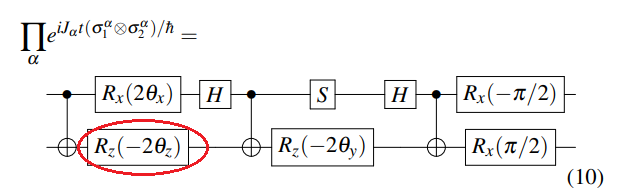

In [3]:
Image(filename='pic/pic1.png')

The optimal circuit of $e^{-i(XX\theta_{1} + YY\theta_{2} + ZZ\theta_{3})}$ from the reference [1] is used. Compared the solution from the example, the number of the CNOT gates is reduced from 6 to 3 with the optimal circuit. I notice there is a small error in the reference, the Rz gate labeled by the red circuit should be + $\theta_{z}$.
<br/>

Three such parameterized circuits "XX+YY+ZZ" which represent $e^{-i\beta (XX + YY + ZZ)}$ with parameters $\beta_{1,2,3}$ are built which will be used late.   

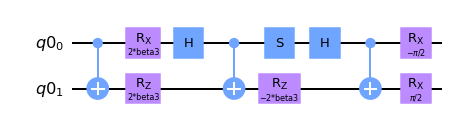

In [4]:
beta1 = Parameter('beta1')
beta2 = Parameter('beta2')
beta3 = Parameter('beta3')

XYZ_qr = QuantumRegister(2)
XYZ_qc = QuantumCircuit(XYZ_qr, name='XX+YY+ZZ')
XYZ_qc.cnot(0,1)
XYZ_qc.rx(2*beta1, 0)
XYZ_qc.rz(2*beta1, 1)
XYZ_qc.h(0)
XYZ_qc.cnot(0,1)
XYZ_qc.s(0)
XYZ_qc.h(0)
XYZ_qc.rz(-2*beta1,1)
XYZ_qc.cnot(0,1)
XYZ_qc.rx(-np.pi/2,0)
XYZ_qc.rx(np.pi/2,1)
XYZ_1 = XYZ_qc.to_instruction()


XYZ_qc = QuantumCircuit(XYZ_qr, name='XX+YY+ZZ')
XYZ_qc.cnot(0,1)
XYZ_qc.rx(2*beta2, 0)
XYZ_qc.rz(2*beta2, 1)
XYZ_qc.h(0)
XYZ_qc.cnot(0,1)
XYZ_qc.s(0)
XYZ_qc.h(0)
XYZ_qc.rz(-2*beta2,1)
XYZ_qc.cnot(0,1)
XYZ_qc.rx(-np.pi/2,0)
XYZ_qc.rx(np.pi/2,1)
XYZ_2 = XYZ_qc.to_instruction()


XYZ_qc = QuantumCircuit(XYZ_qr, name='XX+YY+ZZ')
XYZ_qc.cnot(0,1)
XYZ_qc.rx(2*beta3, 0)
XYZ_qc.rz(2*beta3, 1)
XYZ_qc.h(0)
XYZ_qc.cnot(0,1)
XYZ_qc.s(0)
XYZ_qc.h(0)
XYZ_qc.rz(-2*beta3,1)
XYZ_qc.cnot(0,1)
XYZ_qc.rx(-np.pi/2,0)
XYZ_qc.rx(np.pi/2,1)
XYZ_3 = XYZ_qc.to_instruction()
XYZ_qc.draw('mpl')

I also build a extra circuit "(XX+YY+ZZ)_inv". It is another optimal circuit representation of $e^{-i\beta (XX + YY + ZZ)}$. 
This extra circuit is created by inverting "XX+YY+ZZ" circuit to obtain $e^{i\beta_{1} (XX + YY + ZZ)}$. Then 
change the sign of $\beta_{1}$ to $-\beta_{1}$. 
<br/>
The motivation that I create those circuits will be shown in the following blocks. 

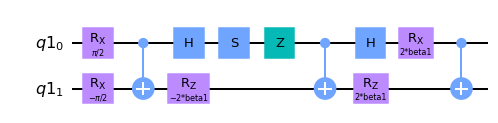

In [5]:
XYZ_qr = QuantumRegister(2)
XYZ_qc = QuantumCircuit(XYZ_qr, name='(XX+YY+ZZ)_inv')
XYZ_qc.rx(-np.pi/2,1)
XYZ_qc.rx(np.pi/2,0)
XYZ_qc.cnot(0,1)
XYZ_qc.rz(-2*beta1,1)
XYZ_qc.h(0)
XYZ_qc.s(0)
XYZ_qc.z(0)
XYZ_qc.cnot(0,1)
XYZ_qc.h(0)
XYZ_qc.rz(2*beta1, 1)
XYZ_qc.rx(2*beta1, 0)
XYZ_qc.cnot(0,1)
XYZ_1_inv = XYZ_qc.to_instruction()
XYZ_qc.draw('mpl')

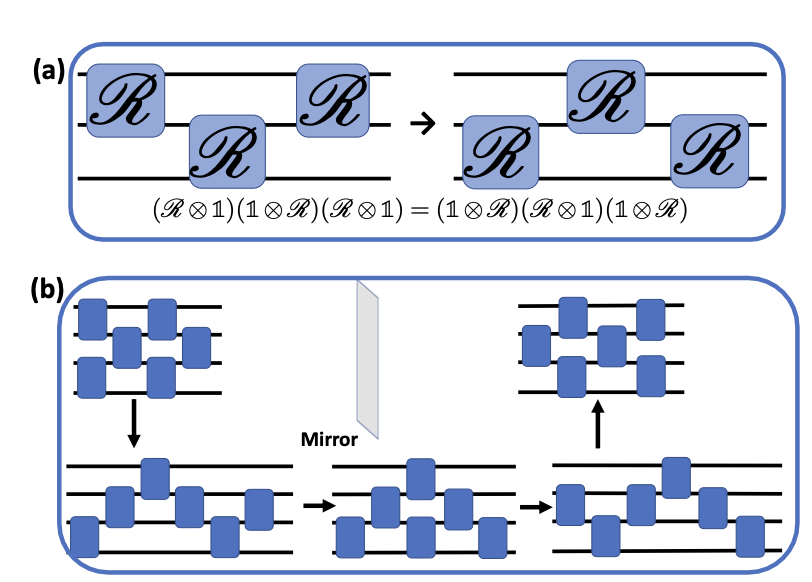

In [6]:
Image(filename='pic/pic2.png')

Yang-Baxter-like mirror relation of the quantum circuit is came up with the references[1]. The main idea for this relation is that try to find a mirrored circuit for the three alternative layers circuit which represents the same unitary operator.     
By applied this mirror relation many times and merge the adjacent layers, any number of the trotter step can be 
represented by a constant depth.
<br/>
However, the authors of the reference [1] only provide the proof and analytical form of this mirror relation for $XY$ Heisenberg model. And in another reference [2], this is a conjecture with the name **Conjecture 3**, and it was found that always exists in $XY$ Heisenberg model. Unfortuntely, I found that this mirror relation do not exist in $XXX$ Heisenberg model (which means no solution).    

Although **Conjecture 3** doesn't work in our case, it will not stop me to find a conjecture relation with more layers. In this solution, I come up with a **Conjecture 5** relation with the analytical form. Instead of find a mirrored circuit for the three alternative layers circuit, I try to find this relation with five alternative layers circuit. I cannot prove that this relation always exists in $XXX$ Heisenberg model. However, all the numerical tests with the different parameters for **Conjecture 5** succeed.  


# Conjecture 5

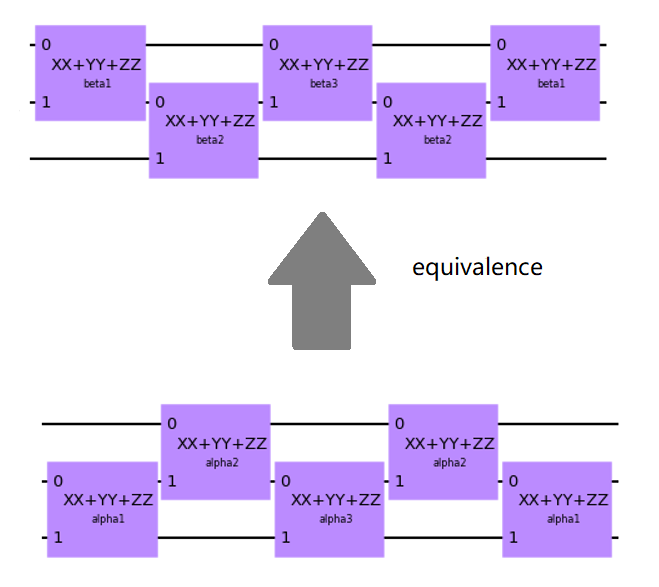

In [7]:
Image(filename='pic/pic3.png')

**Conjecture 5**: <br/>
For any five alternative layers circuit shown above and with the parameterss $\alpha_{1,2,3}$, a corresponding circuit with the parameters $\beta_{1,2,3}$ which represents same unitary operator exist. 
<br/>
<br/>
I add an additional mirror symmetry constraint on the circuit based on invertibility of the circuit. So, only three parameters are used to describe the circuit. 

The analytical form of **Conjecture 5** is shown below:
$$
  f_{1}(2\alpha_{1}, 2\alpha_{2}, 2\alpha_{3}) = f_{1}(2\beta_{1}, 2\beta_{2}, 2\beta_{3})
$$
$$
  f_{2}(2\alpha_{1}, 2\alpha_{2}, 2\alpha_{3}) = f_{2}(2\beta_{1}, 2\beta_{2}, 2\beta_{3})
$$
$$
  f_{3}(2\alpha_{1}, 2\alpha_{2}, 2\alpha_{3}) = f_{4}(2\beta_{1}, 2\beta_{2}, 2\beta_{3})
$$
$$
  f_{4}(2\alpha_{1}, 2\alpha_{2}, 2\alpha_{3}) = f_{3}(2\beta_{1}, 2\beta_{2}, 2\beta_{3})
$$
$$
  f_{5}(2\alpha_{1}, 2\alpha_{2}, 2\alpha_{3}) = f_{5}(2\beta_{1}, 2\beta_{2}, 2\beta_{3})
$$

Where $f_{i}$ are:

$$
f_{1}(x, y, z) = cos(2x)cos(2y) - sin(2x)cos(y)sin(z)
$$

$$
f_{2}(x, y, z) = -sin(x)^{2}sin(2y)cos(z) - cos(x)^{2}sin(y)^{2}sin(z) - 0.5sin(2x)sin(2y)sin(z)
$$

$$
f_{3}(x, y ,z) = cos(2x)cos(y)^{2}sin(z) + sin(2x)cos(2y)cos(z)
$$

$$
f_{4} = cos(x)^{2}sin(2y)cos(z) + sin(x)^{2}sin(y)^{2}sin(z) - 0.5sin(2x)sin(2y)sin(z)
$$

$$
f_{5} = -0.5sin(2x)sin(2y)cos(z) -0.5cos(2x)sin(2y)sin(z) + 0.5sin(2x)sin(y)^{2}sin(z)
$$

The deduction of the analytical form are shown in the appendix.

I create a *mirror_cost* function to return a cost $C$:
$$
C = (f_{1}(2\alpha_{1}, 2\alpha_{2}, 2\alpha_{3}) - f_{1}(2\beta_{1}, 2\beta_{2}, 2\beta_{3}))^{2} + 
(f_{2}(2\alpha_{1}, 2\alpha_{2}, 2\alpha_{3}) - f_{2}(2\beta_{1}, 2\beta_{2}, 2\beta_{3}))^{2} +
(f_{3}(2\alpha_{1}, 2\alpha_{2}, 2\alpha_{3}) - f_{4}(2\beta_{1}, 2\beta_{2}, 2\beta_{3}))^{2} +
(f_{4}(2\alpha_{1}, 2\alpha_{2}, 2\alpha_{3}) - f_{3}(2\beta_{1}, 2\beta_{2}, 2\beta_{3}))^{2} +
(f_{5}(2\alpha_{1}, 2\alpha_{2}, 2\alpha_{3}) - f_{5}(2\beta_{1}, 2\beta_{2}, 2\beta_{3}))^{2}
$$

<br/>

For given $\beta_{1,2,3}$, I numerically optimiza the $C$ to 0 and obtain the correspond $\alpha_{1,2,3}$. Then the mirrored circuit is found. I cannot prove there is always a solution with $C = 0$ (so, It is a conjecture). However, mulitple nurmerical tests are performed which is shown in the appendix. I wish judgers can also test it by themself. 

In [8]:
def f1(x, y, z): # I
    
    f = np.cos(2*x)*np.cos(2*y)*np.cos(z) - np.sin(2*x)*np.cos(y)**2*np.sin(z)
    return f

def f2(x, y, z): # pt-1
    

    f = -np.sin(x)**2*np.sin(2*y)*np.cos(z) - np.cos(x)**2*np.sin(y)**2*np.sin(z) - 0.5*np.sin(2*x)*np.sin(2*y)*np.sin(z)
    return f

def f3(x, y, z): # p
    
    f = np.cos(2*x)*np.cos(y)**2*np.sin(z) + np.sin(2*x)*np.cos(2*y)*np.cos(z)
    return f

def f4(x, y, z): # pt 
    
    f = np.cos(x)**2*np.sin(2*y)*np.cos(z) + np.sin(x)**2*np.sin(y)**2*np.sin(z) - 0.5*np.sin(2*x)*np.sin(2*y)*np.sin(z)
    return f

def f5(x, y, z): # t + t-1
    
    
    f = -0.5*np.sin(2*x)*np.sin(2*y)*np.cos(z) - 0.5*np.cos(2*x)*np.sin(2*y)*np.sin(z) + 0.5*np.sin(2*x)*np.sin(y)**2*np.sin(z)
    return f


def mirror_cost(alphas, *betas): #cost function
    
    alpha1, alpha2, alpha3 = alphas
    beta1, beta2, beta3 = betas

    eq1 = f1(alpha1, alpha2, alpha3) - f1(beta1, beta2, beta3)
    eq2 = f2(alpha1, alpha2, alpha3) - f2(beta1, beta2, beta3)
    eq3 = f3(alpha1, alpha2, alpha3) - f4(beta1, beta2, beta3)
    eq4 = f4(alpha1, alpha2, alpha3) - f3(beta1, beta2, beta3)
    eq5 = f5(alpha1, alpha2, alpha3) - f5(beta1, beta2, beta3)
    
    return eq1**2 + eq2**2 + eq3**2 + eq4**2 + eq5**2

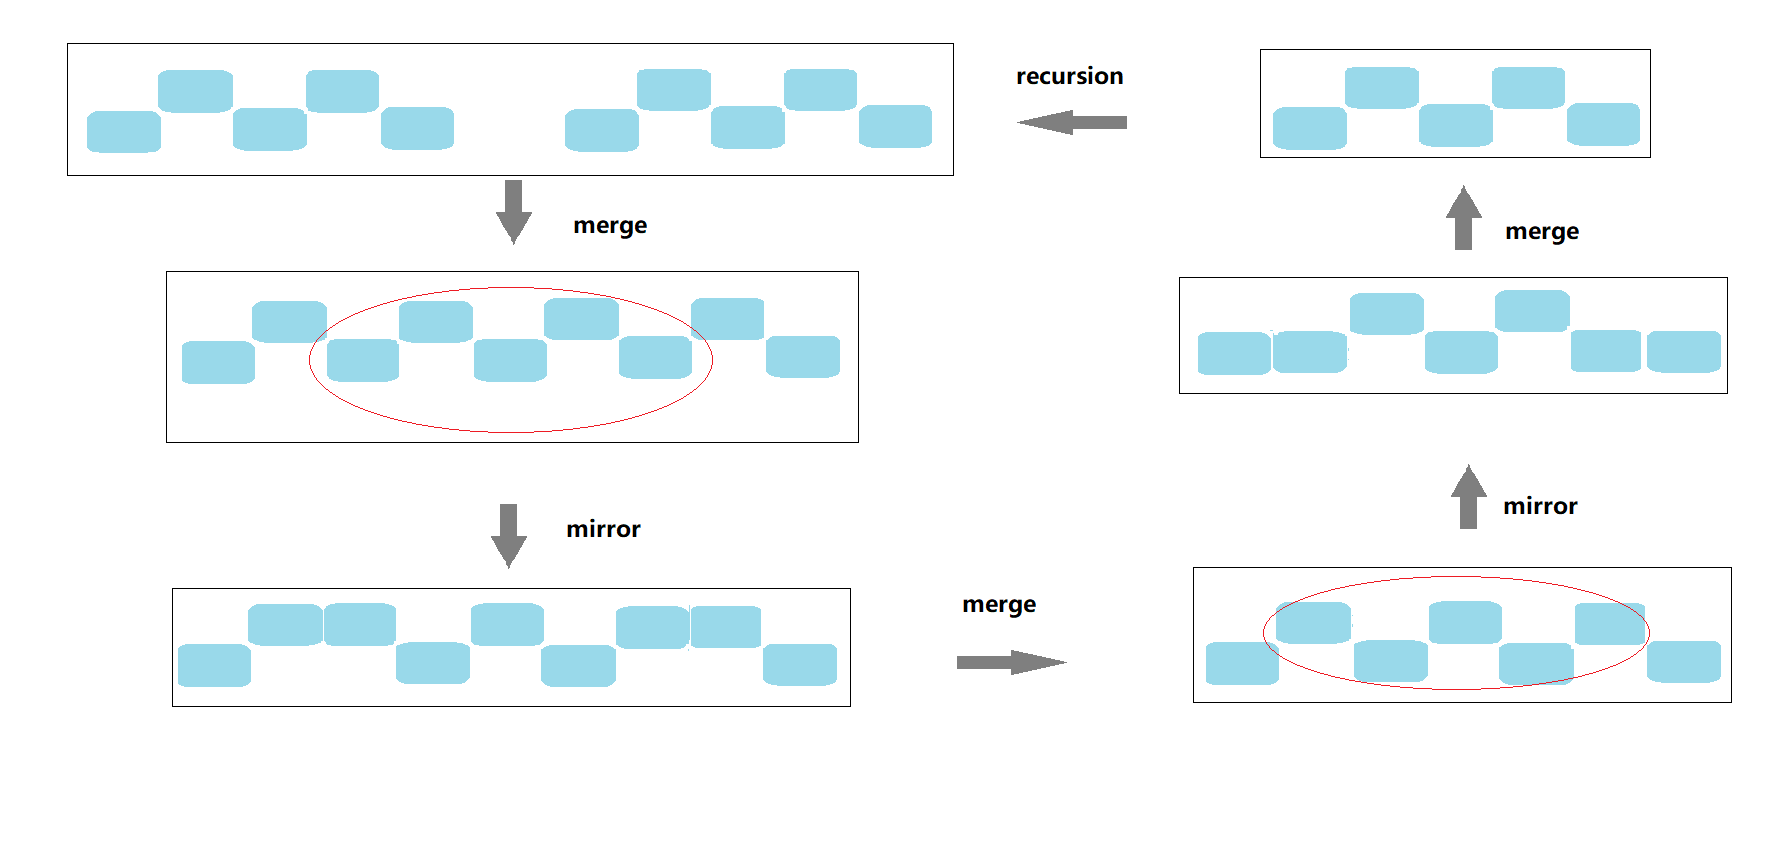

In [9]:
Image(filename='pic/pic5.png')

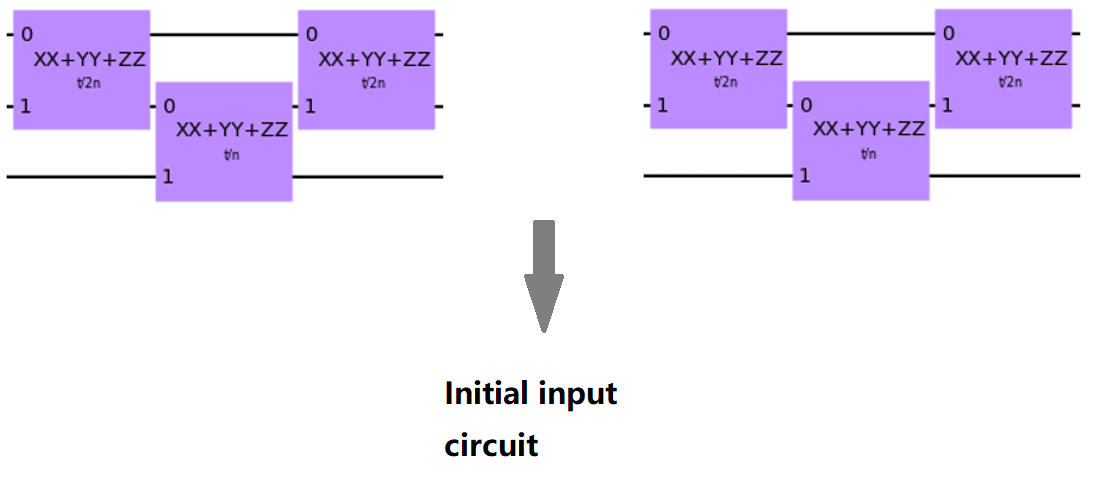

In [10]:
Image(filename='pic/pic6.png')

The calculation of the parameters for the compressed circuit is performed with a function *compression*, which takes the number of the iteration $n$ and total evolution time $t$ as the input. In each iteration, two five alternative layers blocks are compressed into one which is shown above. The output compressed layers from the last iteration enters into the next iteration as the input and algorithm work recursively.
<br/>
In the first iteration, two second-order trotterization are merged into a five alternative layers block as the initial input.
<br/>
With $n$ times iteration, $2^{n+1}$ second-order trotterization steps are compressed into a five alternative layers block. 
<br/>
In *compression* function, *scipy.optimize.basinhopping* is used find the global minimal of the cost function $C$. The search migth repeat many time until the cost function $C < 10^{-16}$ with the searched result.
<br/>
The output of the *compression* are the three parameters for the final compressed circuit which represents $2^{n+1}$ second-order trotterization steps. 



In [11]:
def compression(n, t): # iteration number n and the evolution time t
    
    init_v = -2*t/2**(n+1)
    betas0 = [0.5*init_v, init_v, init_v] #initial input parameters for the second-order trotterization#
    bounds = [(-np.pi, np.pi), (-np.pi, np.pi), (-np.pi, np.pi)]
    
    for i in range(n): #iteration 

        betas=[0,0,0]
        betas[0] = betas0[2]
        betas[1] = betas0[1]
        betas[2] = 2*betas0[0]
        betas[2] = (betas[2]+np.pi) % (2*np.pi) - np.pi
        betas = tuple(betas)
        for j in range(2):
            minimizer_kwargs = {"args":betas, "bounds": bounds,"method":"L-BFGS-B", "jac":"3-point"}
            cost = 1
            while cost > 1e-16: # Only when cost less than 10^(-16), the optimization is passed.  

                result = basinhopping(
                              mirror_cost, 
                              deepcopy(betas), 
                              minimizer_kwargs=minimizer_kwargs, 
                              niter=1000,
                              stepsize = 0.2,
                              T = 3.
                                 )
                cost = result.fun
    
            alphas = deepcopy(result.x)
            alphas[0]+=betas0[1-j] # merge the parameters of the adjacent layers
            alphas[0] = (alphas[0]+np.pi) % (2*np.pi) - np.pi # keep the parameters within the range
            betas = tuple(deepcopy(alphas))
        betas0 = list(betas)
    paras = [-betas0[0]/2., -betas0[1]/2., -betas0[2]/2.]
    return paras # return the paramters for the final compressed circuit

In the cell below, the parameters of the compressed circuit with the target evolution time $\pi$ is calculated. I also tested evolution time $\pi/2$ and calculate the circuit parameters for it. In principal, any number of the steps of the trotterization can be represented by this compressed circuit. In my study, the circuit compression is performed with five iterations and totally 64 steps of the second-order since the result is good enough. 

It takes 5 to 10 minutes to run the next cell and calculate the compressed circuit parameters for evolution time $\pi$ and $\pi/2$. 

In [12]:
target_time = np.pi
paras_pi = compression(5, target_time) # compressed circuit parameters for evolution time pi
paras_half_pi = compression(5, target_time/2.) # compressed circuit parameters for evolution time pi/2

In the next cell, the compressed trotterization circuit for evolution time $\pi$ is created. 

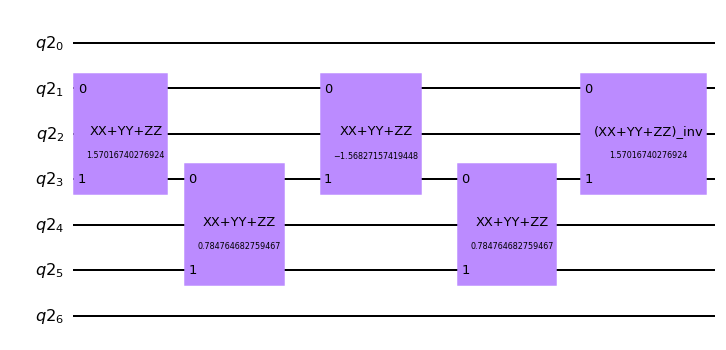

In [13]:
num_qubits = 7
qr = QuantumRegister(num_qubits)
Trot_qc = QuantumCircuit(qr, name='Trot_pi')
Trot_qc.append(XYZ_1, [qr[1], qr[3]])
Trot_qc.append(XYZ_2, [qr[3], qr[5]])
Trot_qc.append(XYZ_3, [qr[1], qr[3]])
Trot_qc.append(XYZ_2, [qr[3], qr[5]])
Trot_qc.append(XYZ_1_inv, [qr[1], qr[3]])
Trot_qc=Trot_qc.bind_parameters({beta1:paras_pi[0],beta2:paras_pi[1], beta3:paras_pi[2]})
Trot_pi = Trot_qc.to_instruction()
Trot_qc.draw('mpl')

In the next cell, the entire trotterization circuit is optimized to the empty which *optimization_level=3* during the transpile, which means do nothing with the input quantum state.
<br/>
I provide the eigenstate and eigenvalue of of the target Hamiltonian in the appendix. The eigenvalues of the target Hamiltonian are $[-4, 0 ,2]$, and the target evolution time $\pi$ is a special case with this set of the eigenvalues. The noiseless evolved state must be the input state since: 
$$
U = e^{-itH} = e^{-i(-4/2/0)\pi} = 1
$$

So, a empty circuit and do nothing is the optimal solution with this special evolution time. In principal, I can use this empty circuit, since my method with the IBM circuit optimization algorithm for this specific evolution time reduce 64 steps of the trotterization to a empty circuit. It will give a extremely high fidelity, which is more than 0.99 after the error mitigation to reduce the readout error.
<br/>
However, it is still unclear that if it is a reasonable solution and lay in the scope of the challenge. Given this situation, I will still keep the five alternative layers circuit as the basic structure in **Conjecture 5**, and do not optimize it regarding the evolution time. I will also test my solution with the envolution time $\pi/2$ which is not so special.   

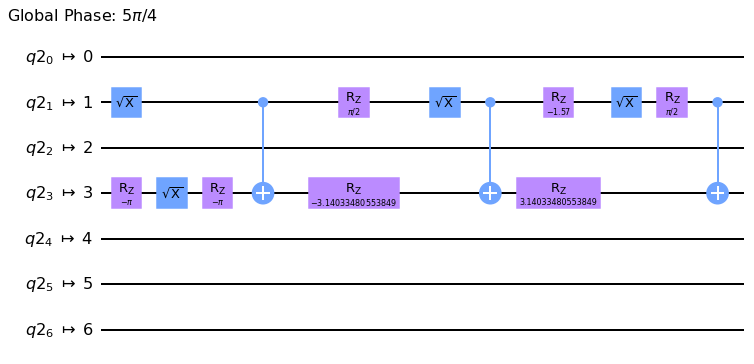

In [14]:
Trot_test = transpile(Trot_qc, optimization_level=3,backend=sim_noisy_jakarta)

Trot_test.draw('mpl')

In the following cell, *approximation_degree=1.* will help me to keep the basic structure of the circuit. 

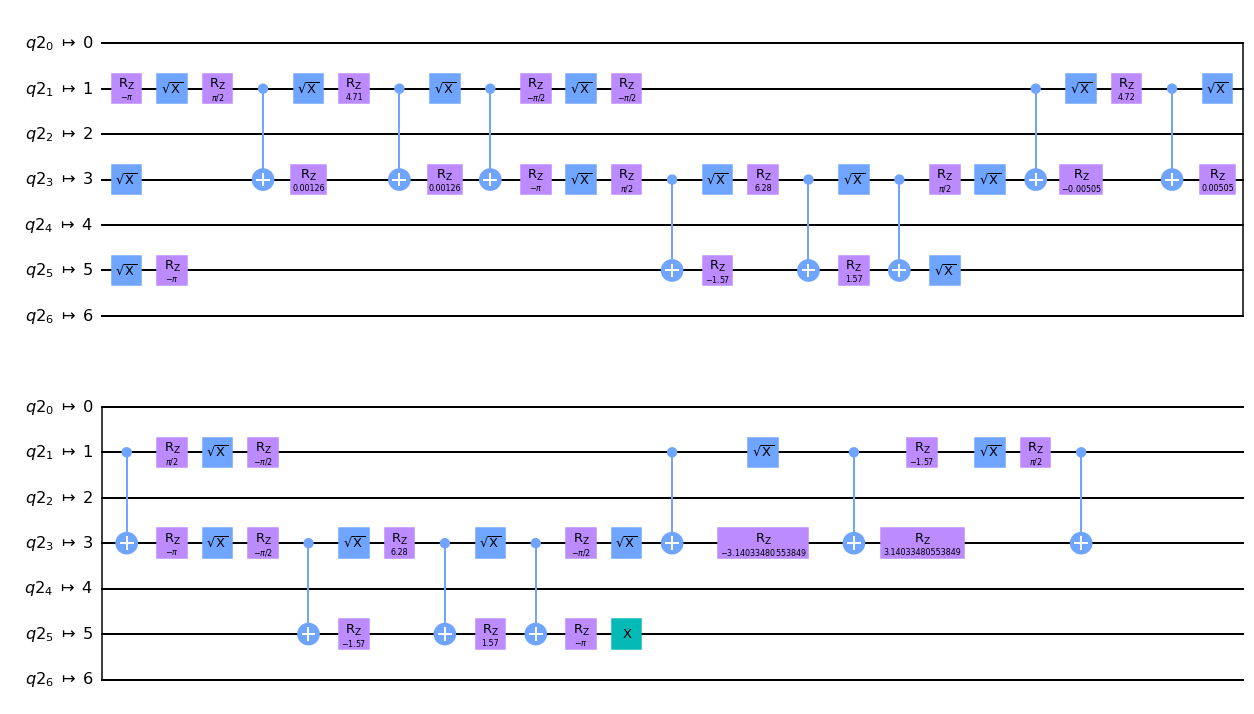

In [15]:
Trot_test = transpile(Trot_qc, optimization_level=3,backend=sim_noisy_jakarta, approximation_degree=1.)

Trot_test.draw('mpl')

In the following cell, compressed trotterization circuit for evolution time $\pi/2$ is created.

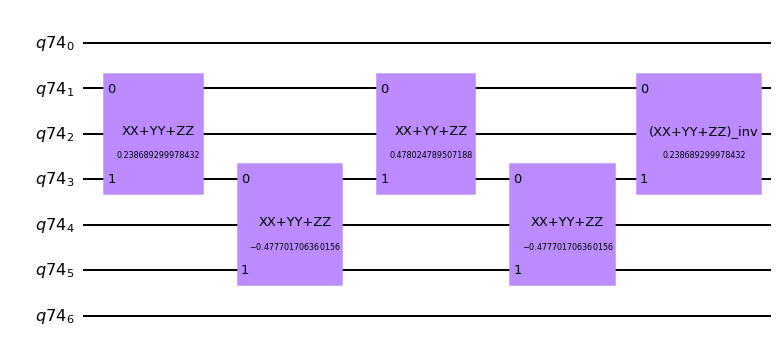

In [16]:
num_qubits = 7
qr = QuantumRegister(num_qubits)
Trot_qc = QuantumCircuit(qr, name='Trot_half_pi')
Trot_qc.append(XYZ_1, [qr[1], qr[3]])
Trot_qc.append(XYZ_2, [qr[3], qr[5]])
Trot_qc.append(XYZ_3, [qr[1], qr[3]])
Trot_qc.append(XYZ_2, [qr[3], qr[5]])
Trot_qc.append(XYZ_1_inv, [qr[1], qr[3]])
Trot_qc=Trot_qc.bind_parameters({beta1:paras_half_pi[0],beta2:paras_half_pi[1], beta3:paras_half_pi[2]})
#Trot_qc = transpile(Trot_qc, optimization_level=3,backend=jakarta, approximation_degree=1.)
Trot_half_pi = Trot_qc.to_instruction()
Trot_qc.draw('mpl')

So, the simulation with the evolution time $\pi$ is really a special case. With the evolution time $\pi/2$, the transpile do not change the ciruit structure even without *approximation_degree=1.*. 

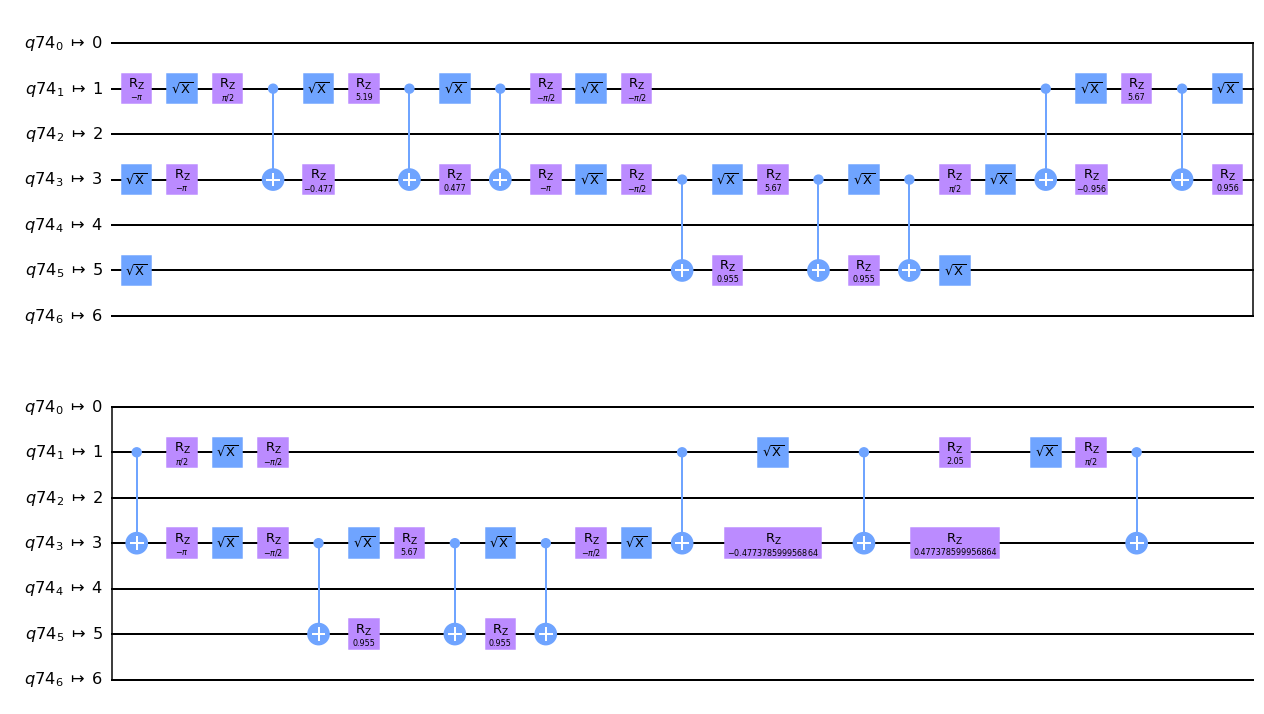

In [17]:
Trot_test = transpile(Trot_qc, optimization_level=3,backend=sim_noisy_jakarta)

Trot_test.draw('mpl')

The circuits for the different input states are created below. We test our solution with the input states $|110>$ and $(|010>+|110>)/\sqrt{2}$.

In [18]:
qr = QuantumRegister(7)
qc = QuantumCircuit(qr, name = "target_input")
qc.x([3,5])
qc.barrier(qr)
target_input = qc.to_instruction()

qr = QuantumRegister(7)
qc = QuantumCircuit(qr, name = "ext_input")
qc.x(3)
qc.h(5)
qc.barrier(qr)
ext_input = qc.to_instruction()

In addition to the circuit compression, I also apply a post-selection based on symmetry verfication technique []. An ancillary qubit is used as the flag to find all the shots which violate the specific symmetry of the Hamlitonian. 
<br/>
It is easy to check that the target Hamlitonian commutes with the operators $XXX$, $YYY$, $ZZZ$. In my solution, I build a verfication circuit with qubit 4 (because of the long T2 lifetime of qubit 4) to rule out any shot that violates the $ZZZ$ symmetry. The verfication circuit is represented as:
$$
G = 0.5*(III-ZZZ)I + 0.5*(III+ZZZ)X
$$
Where in $PPPP$, $P$ is the pauli operators in the code space of qubit 1, 3, 5, 4 from left to right.
<br/>
It is easy to verify that:
$$
G = G^{+}
$$
$$
GG^{+} = IIII
$$
$$
[G, H_{heisen}] = 0
$$

$$
GH_{heisen}G^{+} = H_{heisen}
$$

Where $H_{heisen}$ is the target Hamiltonian of the $XXX$ Heisenberg model. The equations above show that if we perform a noiseless simulation, the simulated result of the circuit for $GH_{heisen}G^{+}$ is identical to the circuit for $H_{heisen}$. 
<br/>
For any operator $O = P_{1}P_{2}P_{3}$ in qubit 1, 3, 5 code space and anticommute with $ZZZ$: 
$$
GOG^{+} = (O)(IIIX) = P_{1}P_{2}P_{3}X
$$

Then, by adding this circuit G in two sides of the the main five alternative layers circuit $H_{heisen}$, the qubit 4 will be flipped from "0" to be "1" with the shot of the simulation which suffers from the anticommute noise $O$.
<br/>
By measuring qubit 4 and selecting out all the shots with state "1" on it. All the noise which anticommute with $ZZZ$ are reduced(remove $O$ which anticommutes with $ZZZ$ from all the Kraus operators of the noise quantum channel).   

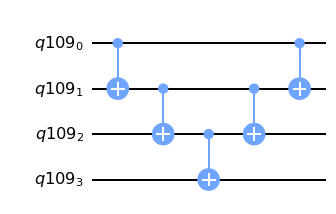

In [19]:
# construction of the verification circuit G
num_qubits = 4
qr = QuantumRegister(num_qubits)
zzz_qc = QuantumCircuit(qr, name='G')
zzz_qc.cnot(0, 1)
zzz_qc.cnot(1, 2)
zzz_qc.cnot(2, 3)
zzz_qc.cnot(1, 2)
zzz_qc.cnot(0, 1)
zzz = zzz_qc.to_instruction()
zzz_qc.draw('mpl')

In the following cell, I wrap all the circuits for the target state and time. Notice that I use "(XX+YY+ZZ)_inv" in the last alternative layer of the compressed trotterization circuit. By this way, two CNOTs gates in the adjacent area between the verfication circuit $G$ and compressed circuit are cancelled in the right side. This cancellation also happens in the left side.   
<br/>
After transpile, the depth of the CNOTS for the circuit is 19.  

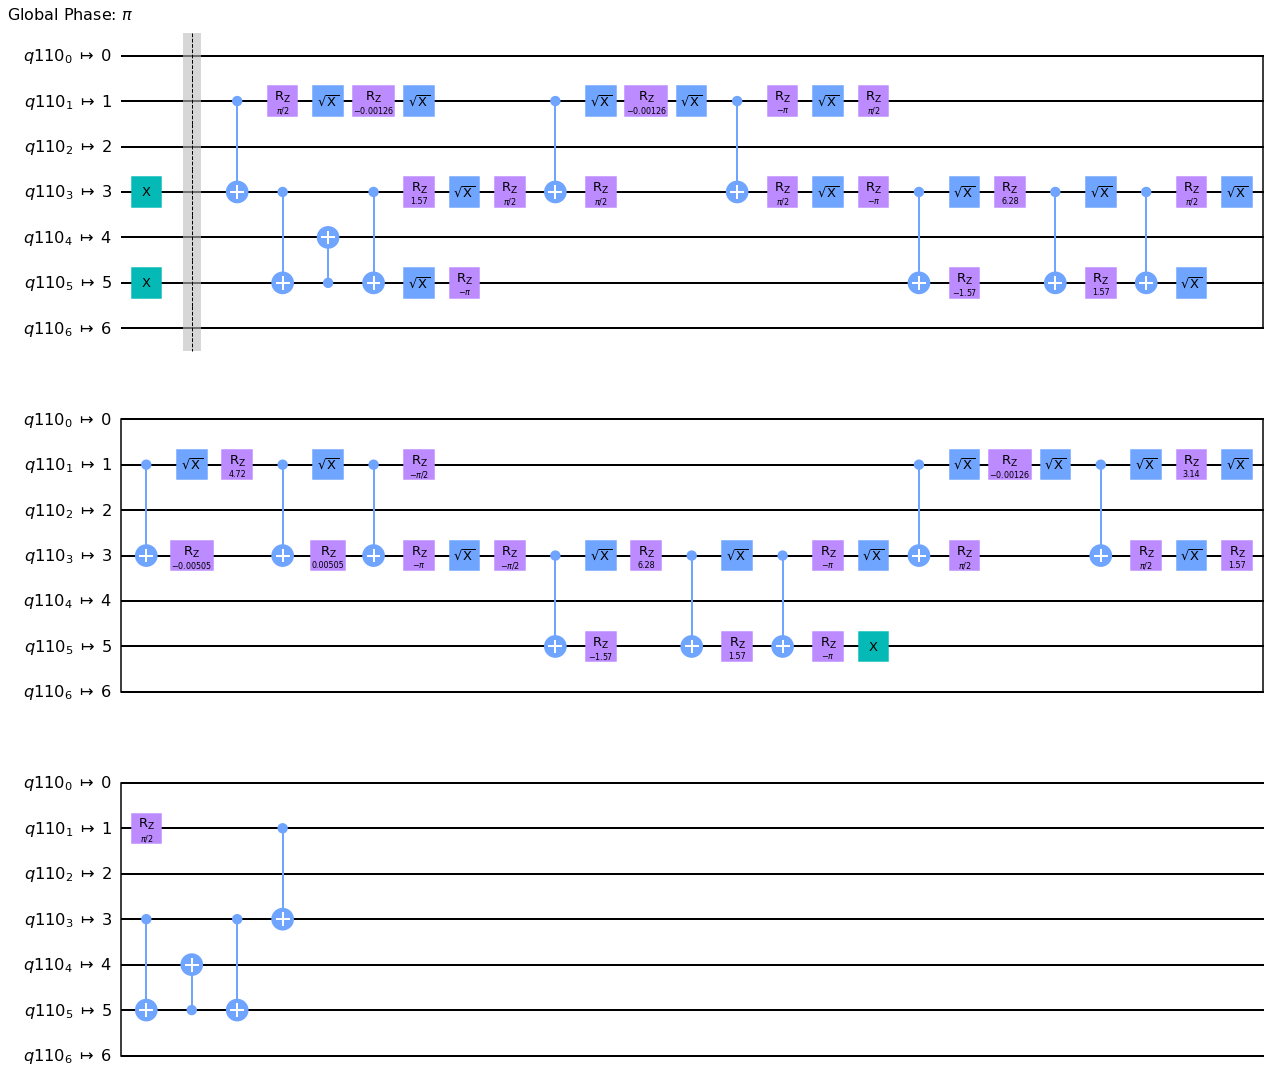

In [20]:
qr = QuantumRegister(7)
qc = QuantumCircuit(qr)

qc.append(target_input, [qr[0], qr[1], qr[2], qr[3], qr[4], qr[5], qr[6]])
qc.append(zzz, [qr[1], qr[3], qr[5], qr[4]])
qc.append(Trot_pi, [qr[0], qr[1], qr[2], qr[3], qr[4], qr[5], qr[6]])
qc.append(zzz, [qr[1], qr[3], qr[5], qr[4]])
qc_target = transpile(qc, optimization_level=3,backend=sim_noisy_jakarta, approximation_degree=1.)
qc_target.draw('mpl')

The tomograph circuits are created in the following cell. Two sets of the tomograph circuit are created.  *st_qcs_target_m* is the set of the circuits which are sent to the device, and the measurement is also performed on qubit 4 for the purpose of symmetry verification in this set of the circuits. The state tomograph is only performed in qubit 1, 3, 5 and *st_qcs* is created for the purpose of creating the *tomo_fitter* object from *StateTomographyFitter*.      

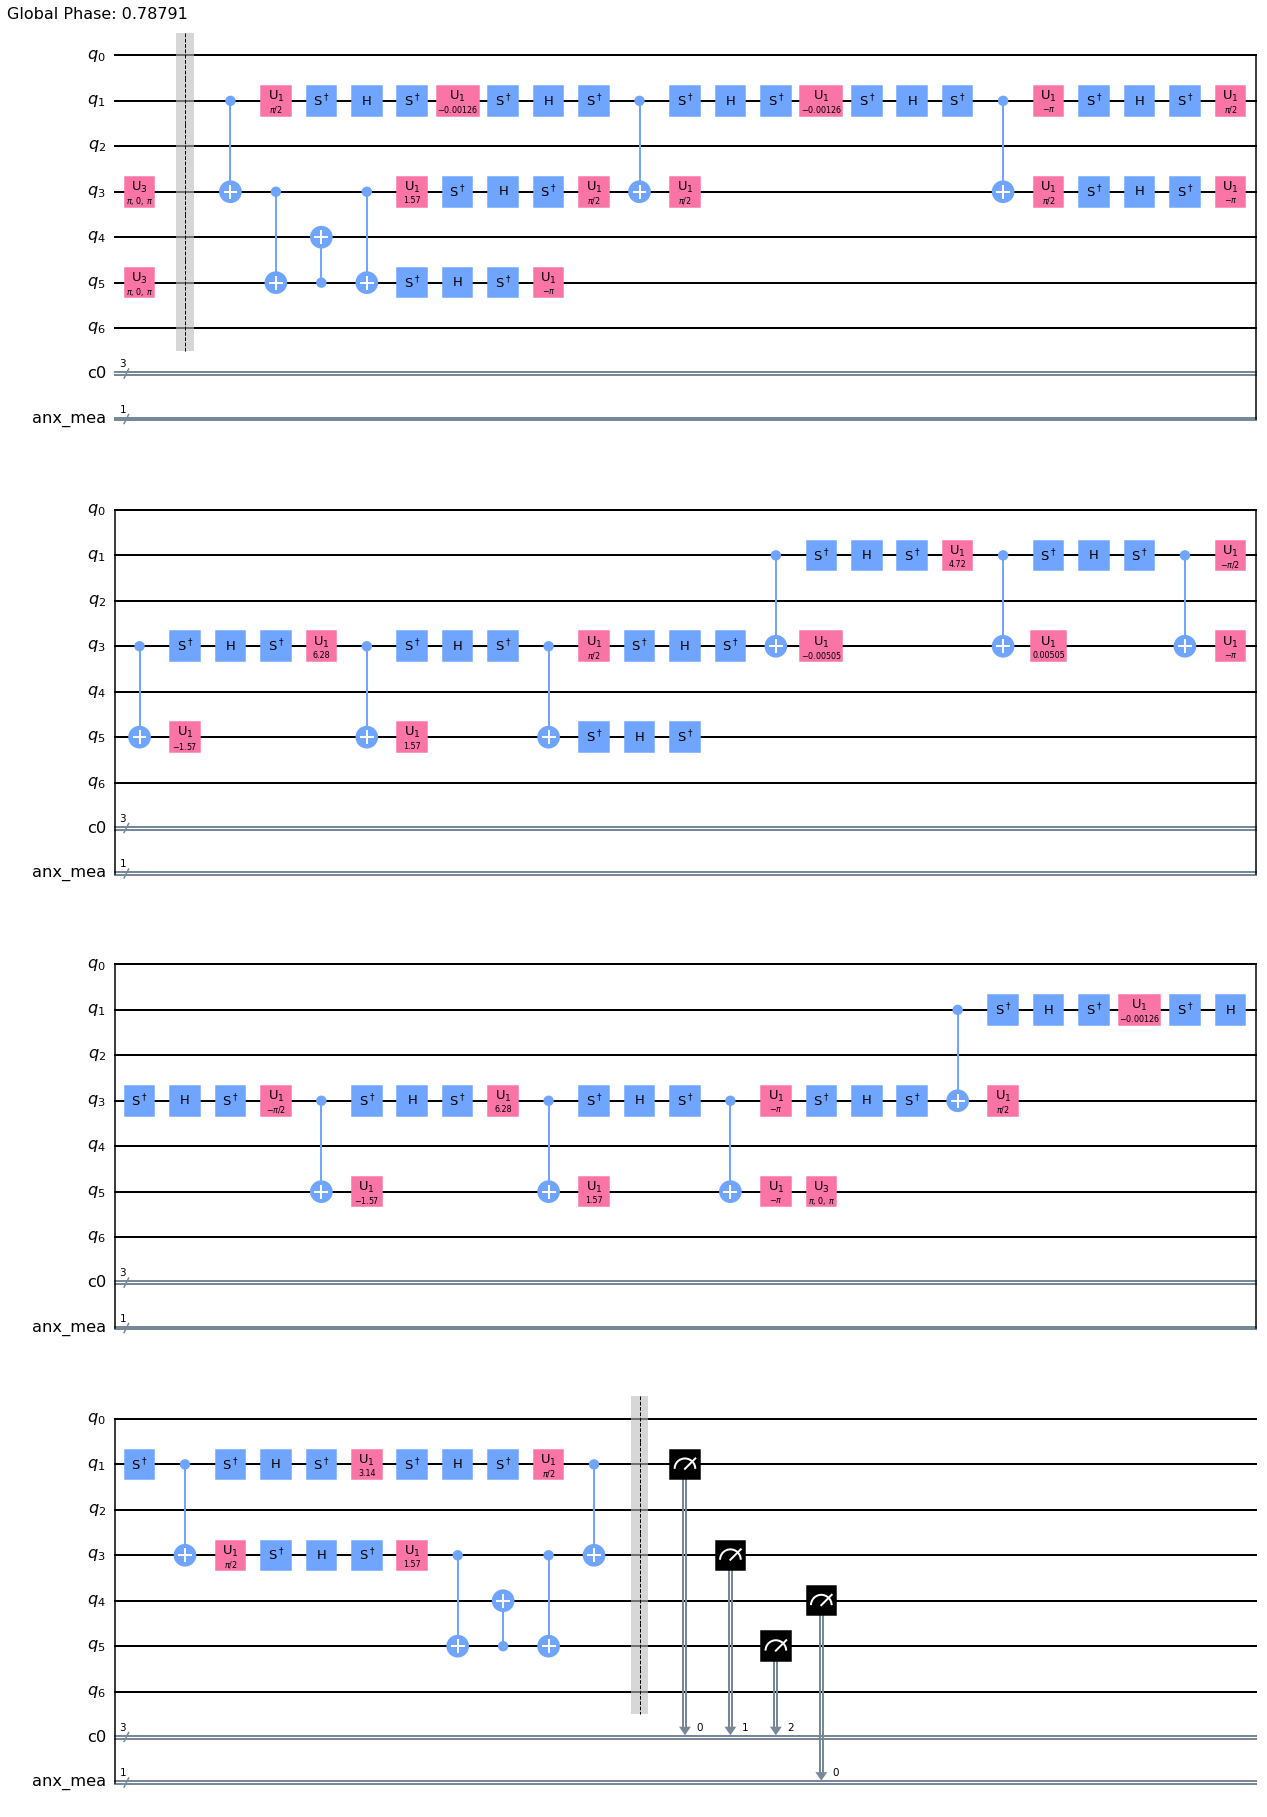

In [21]:
st_qcs_target_m = state_tomography_circuits(qc_target, [1,3,5])
st_qcs_target = []
for st_qc in st_qcs_target_m:
    st_qcs_target.append(st_qc.copy())
    cr=ClassicalRegister(1, "anx_mea")
    st_qc.add_register(cr)
    st_qc.measure([4], [cr[0]])

st_qcs_target_m[-1].decompose().draw('mpl')

In here, I sent jobs to the noise backend as the example. The jobs was ran in real device and the IDs are provided late.

In [22]:
shots = 8192
reps = 8
#backend=sim
backend = sim_noisy_jakarta
#backend = jakarta

jobs_target = []
for _ in range(reps):
    # execute
    job = execute(st_qcs_target_m, backend, shots=shots, optimization_level=0) # optimization is set to be 0 to avoid any unpredictable optimization
    print('Job ID', job.job_id())
    jobs_target.append(job)
    

Job ID 7faae04d-1210-4b9f-a54e-17c7ea3d4905
Job ID a4050ab4-7b9c-41c6-ba2b-e37ada00f6f5
Job ID 7f7defab-b946-44eb-a9e3-50bda2d3c700
Job ID 1c91d2b1-6511-4361-a655-9d129d2c7bbe
Job ID d9116a8e-fa59-4a63-b4a4-7e4025a02d06
Job ID 149c82e9-72d1-45ce-ab1a-a6c71de54fe9
Job ID 38a9af6f-476d-4821-ad86-307621d4c92b
Job ID 8a7d2652-c0b6-400a-adc2-4fbdfab86da6


The state_tomo function is defined below with the input job result, tomograph circuits without measurement in qubit 4, and the noiseless target output state.

In [23]:
def state_tomo(result, st_qcs, target_state):
    tomo_fitter = StateTomographyFitter(result, st_qcs)
    rho_fit = tomo_fitter.fit(method='lstsq')
    fid = state_fidelity(rho_fit, target_state)
    return fid

I also define a function *get_target_state* to calculate the noiseless target output state with any input initial state and evolution time $t$.  

In [24]:
def H_heis3():
    # Interactions (I is the identity matrix; X, Y, and Z are Pauli matricies; ^ is a tensor product)
    XXs = (I^X^X) + (X^X^I)
    YYs = (I^Y^Y) + (Y^Y^I)
    ZZs = (I^Z^Z) + (Z^Z^I)
    
    # Sum interactions
    H = XXs + YYs + ZZs
    
    # Return Hamiltonian
    return H

def U_heis3(t):
    # Compute XXX Hamiltonian for 3 spins in a line
    H = H_heis3()
    
    # Return the exponential of -i multipled by time t multipled by the 3 spin XXX Heisenberg Hamilonian 
    return (t * H).exp_i()

def get_target_state(t, initial_state):
    
    state = (U_heis3(float(t)) @ initial_state).eval()
    state = state.to_matrix()
    state = qi.Statevector(state)
    return state

In this solution, a default version of the error mitigation is ran to suppress the readout error for qubit 1, 3, 5, 4. The information is provide from the qiskit tutorial:https://qiskit.org/textbook/ch-quantum-hardware/measurement-error-mitigation.html

In [25]:
shots =2**16 # 2^16 shots are ran with 8 times to have a good statistics for the unfolding
backend = sim_noisy_jakarta
#backend = jakarta
qr = QuantumRegister(7)
meas_calibs, state_labels = complete_meas_cal(qubit_list=[4, 1, 3, 5], qr=qr, circlabel='mcal')
jobs_readout = []
for _ in range(8):
    # execute
    job = execute(meas_calibs, backend, shots=shots, optimization_level=None)
    print('Job ID', job.job_id())
    jobs_readout.append(job)

print('Job ID', job.job_id())

Job ID 339174e5-fc70-4847-bec4-91899fbec4a8
Job ID 76e2deb8-1add-4481-8722-d8446c80a164
Job ID 59549e6d-cc86-46d0-a1c6-0ffb79708fb2
Job ID 2f468f0e-1673-40a3-b2a0-b80729ec0709
Job ID ed4f237a-42c3-4d75-8cb6-6f837241225a
Job ID d461c657-e3ea-435d-88a1-874d78587a3a
Job ID ba9f30c2-9b69-4451-bf76-b14b47d26f07
Job ID 4754564a-7d7d-4fc7-9806-7fd5949b4fee
Job ID 4754564a-7d7d-4fc7-9806-7fd5949b4fee


IOStream.flush timed out


In the following cell, the state label of the error mitigator is modified to match the state labels of *st_qcs_target_m*.

In [26]:

results = [job.result() for job in jobs_readout]
meas_fitter = CompleteMeasFitter(results, state_labels, circlabel='mcal')
err_mitig = copy.deepcopy(meas_fitter)

for i in range(len(meas_fitter.state_labels)):
    state_label_raw = meas_fitter.state_labels[i]
    state_label = state_label_raw[0] + ' ' + state_label_raw[1:4]
    err_mitig.state_labels[i] = state_label

In the following cell, the post-process and state fidelity calculation is performed for the noise simulation. And some of codes are use create a new result object with the three qubit state labels for the tomograph and the counts after the post-selection based on the symmetry verfication.


In [27]:
target_state = get_target_state(target_time ,One^One^Zero)

fids = []
for job in jobs_target:
    raw_results = job.result()
    raw_results = err_mitig.filter.apply(raw_results) # error mitigation 
    new_results = copy.deepcopy(raw_results) # create a new result object
    for resultidx, _ in enumerate(raw_results.results):
        old_counts = raw_results.get_counts(resultidx)
        new_counts = {}
        #built right state label
        new_results.results[resultidx].header.creg_sizes = [new_results.results[resultidx].header.creg_sizes[0]]
        new_results.results[resultidx].header.clbit_labels = new_results.results[resultidx].header.clbit_labels[0:-1]
        new_results.results[resultidx].header.memory_slots = 3
        
        for reg_key in old_counts:
            reg_bits = reg_key.split(' ')
            if reg_bits[0]=='0': # select only the count with qubit 4 "0"
                new_counts[reg_bits[1]]=old_counts[reg_key] # build right state label 
       
        new_results.results[resultidx].data.counts = new_counts

    fid = state_tomo(new_results, st_qcs_target, target_state)
    fids.append(fid)
    
print('state tomography fidelity for target time and initial state = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

state tomography fidelity for target time and initial state = 0.9473 ± 0.0029


In the following cell, I retrieve the jobs which were ran on real device on April 15th.

In [28]:
ids= [
     "62539c5a73968c8de707cf7a",
     "62539c5c5ab79bc3fef96f68",
     "62539c5ed720334e5267f5b7",
     "62539c61cfe45cce35e5c0a3",
     "62539c6273968c7c4c07cf7b",
     "62539c64f65d787612392084",
     "62539c654b51525f2a7c8865",
     "62539c67a5d4eef9ad77eaba",
     ]
jobs_target = []
for idx in ids:
    job = jakarta.retrieve_job(idx)
    jobs_target.append(job)

The creation date of the jobs are printed 

In [29]:
for job in jobs_target:
    
    print(job.creation_date())

2022-04-10 23:11:22.850000-04:00
2022-04-10 23:11:24.900000-04:00
2022-04-10 23:11:26.615000-04:00
2022-04-10 23:11:29.725000-04:00
2022-04-10 23:11:30.869000-04:00
2022-04-10 23:11:32.413000-04:00
2022-04-10 23:11:33.655000-04:00
2022-04-10 23:11:34.999000-04:00


To obtain the best fidelity, I retrieve the calibration state of noise simulation backend when the job was ran in real device.

In [30]:
sim_noisy_jakarta.properties=jobs_target[3].properties
#sim_noisy_jakarta.properties.__init__(last_update_date = "Apr 15, 2022 7:44 AM")

In [31]:
shots =2**16
backend = sim_noisy_jakarta
#backend = jakarta
qr = QuantumRegister(7)
meas_calibs, state_labels = complete_meas_cal(qubit_list=[4, 1, 3, 5], qr=qr, circlabel='mcal')
jobs_readout = []
for _ in range(8):
    # execute
    job = execute(meas_calibs, backend, shots=shots, optimization_level=None)
    print('Job ID', job.job_id())
    jobs_readout.append(job)

print('Job ID', job.job_id())


Job ID 5611d673-dbae-4377-89ef-11705ae248c1
Job ID 65c59048-1d78-46ae-9413-3f916f65f75f
Job ID e8953c14-4816-4601-87f5-329d5ef2d003
Job ID c5470e02-ac11-42a5-a202-0a7cd9c04f09
Job ID a0b8e13d-6bf9-4451-8339-41a69f4308e2
Job ID 30ad0b81-61fc-461a-bde7-b7ba46f0a2d6
Job ID 34ebbf40-038c-44a8-8345-5673436db874
Job ID 8c2612a7-f3f5-408b-be5b-944234eb1714
Job ID 8c2612a7-f3f5-408b-be5b-944234eb1714


In [32]:
results = [job.result() for job in jobs_readout]
meas_fitter = CompleteMeasFitter(results, state_labels, circlabel='mcal')
err_mitig = copy.deepcopy(meas_fitter)

for i in range(len(meas_fitter.state_labels)):
    state_label_raw = meas_fitter.state_labels[i]
    state_label = state_label_raw[0] + ' ' + state_label_raw[1:4]
    err_mitig.state_labels[i] = state_label

A state tomography fidelity $0.8757 \pm 0.0035$ is obtained.

In [33]:
target_state = get_target_state(target_time ,One^One^Zero)

fids = []
for job in jobs_target:
    raw_results = job.result()
    raw_results = err_mitig.filter.apply(raw_results)
    new_results = copy.deepcopy(raw_results)
    for resultidx, _ in enumerate(raw_results.results):
        old_counts = raw_results.get_counts(resultidx)
        new_counts = {}
        new_results.results[resultidx].header.creg_sizes = [new_results.results[resultidx].header.creg_sizes[0]]
        new_results.results[resultidx].header.clbit_labels = new_results.results[resultidx].header.clbit_labels[0:-1]
        new_results.results[resultidx].header.memory_slots = 3
        
        for reg_key in old_counts:
            reg_bits = reg_key.split(' ')
            if reg_bits[0]=='0':
                new_counts[reg_bits[1]]=old_counts[reg_key]
       
        new_results.results[resultidx].data.counts = new_counts

    fid = state_tomo(new_results, st_qcs_target, target_state)
    fids.append(fid)
    
print('state tomography fidelity for target time and initial state = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

state tomography fidelity for target time and initial state = 0.8758 ± 0.0035


The T1 and T2 lifetime of the qubit is supposed to be extended with the DD [4]. In the following cell, I add DD in my solution. I implement the DD with $XYXY$ series by hand on qubit 1, 3 and the ancillary qubit 4. 
<br/>
In the following cell, *gen_dd* function is used to create the DD series with the different interval of the pulse and the number of the repetitions of $XYXY$ series.   

In [34]:
def gen_dd(n, rep): # n is the number of the gate time between the two pulses, and rep is the he number of the repetitions of XYXY series 

    num_qubits = 1
    dd_qr = QuantumRegister(num_qubits)
    dd_qc = QuantumCircuit(dd_qr, name='dd')
    dd_qc.barrier(0)
    for _ in range(2*rep):
        dd_qc.x(0)
        dd_qc.barrier(0)
        for _ in range(n):
            dd_qc.id(0)
            dd_qc.barrier(0)

        dd_qc.rz(-np.pi, 0)
        dd_qc.x(0)
        dd_qc.barrier(0)
        for _ in range(n):
            dd_qc.id(0)
            dd_qc.barrier(0) 
    return dd_qc

*dd_circuit* function is used to add DD on the input circuit. Due to the time limit, I cannot give a best DD strategy. However I have a study of the effect of the interval of the pulse on the individual qubit (which is shown in appendix). According to this study, I will use 2 gate time interval for qubit 1 and 4, and 1 gate time interval for qubit 5. 

In [35]:
def dd_circuit(input_qc):

    qr = QuantumRegister(7)
    qc = QuantumCircuit(qr)
    dd1 = gen_dd(1, 1)
    qc.append(dd1, [qr[5]])
    qc_dd5 = transpile(qc, optimization_level=0,backend=sim_noisy_jakarta)

    qr = QuantumRegister(7)
    qc = QuantumCircuit(qr)
    dd2 = gen_dd(2, 1)
    qc.append(dd2, [qr[1]])
    qc_dd1 = transpile(qc, optimization_level=0,backend=sim_noisy_jakarta)

    qr = QuantumRegister(7)
    qc = QuantumCircuit(qr)
    dd3 = gen_dd(2, 1)
    qc.append(dd3, [qr[4]])
    qc_dd4 = transpile(qc, optimization_level=0,backend=sim_noisy_jakarta)
    
    qr = QuantumRegister(7)
    dd_qc = QuantumCircuit(qr)
    dd_qc = transpile(dd_qc, optimization_level=0,backend=sim_noisy_jakarta, approximation_degree=1.)
    dd_qc.data = input_qc.data[:11]
    for i in range(2):
        dd_qc.data += qc_dd1.data
    for i in range(3):
        dd_qc.data += qc_dd5.data
    for i in range(13):
        dd_qc.data += qc_dd4.data    
    dd_qc.data += input_qc.data[11:24] 
    for i in range(2):
        dd_qc.data += qc_dd1.data
    dd_qc.data += input_qc.data[24:36]
    for i in range(4):
        dd_qc.data += qc_dd5.data
    dd_qc.data += input_qc.data[36:48]
    for i in range(2):
        dd_qc.data += qc_dd1.data
    dd_qc.data += input_qc.data[48:57] 
    for i in range(3):
        dd_qc.data += qc_dd5.data
    dd_qc.data += input_qc.data[57:-4]
    for i in range(2):
        dd_qc.data += qc_dd1.data

    dd_qc.data += input_qc.data[-4:]
    
    return dd_qc

In [36]:
qr = QuantumRegister(7)
qc = QuantumCircuit(qr)

qc.append(zzz, [qr[1], qr[3], qr[5], qr[4]])
qc.append(Trot_pi, [qr[0], qr[1], qr[2], qr[3], qr[4], qr[5], qr[6]])
qc.append(zzz, [qr[1], qr[3], qr[5], qr[4]])
qc = transpile(qc, optimization_level=3,backend=sim_noisy_jakarta, approximation_degree=1.)
dd_qc = dd_circuit(qc)

In the next two cells, I draw the pulse schedule for the circuit without DD and with DD to check if DD is implemneted correctly.
<br/>
I need to stress that I just draw the pulse schedule for the default gate, and this is still a gate based solution.

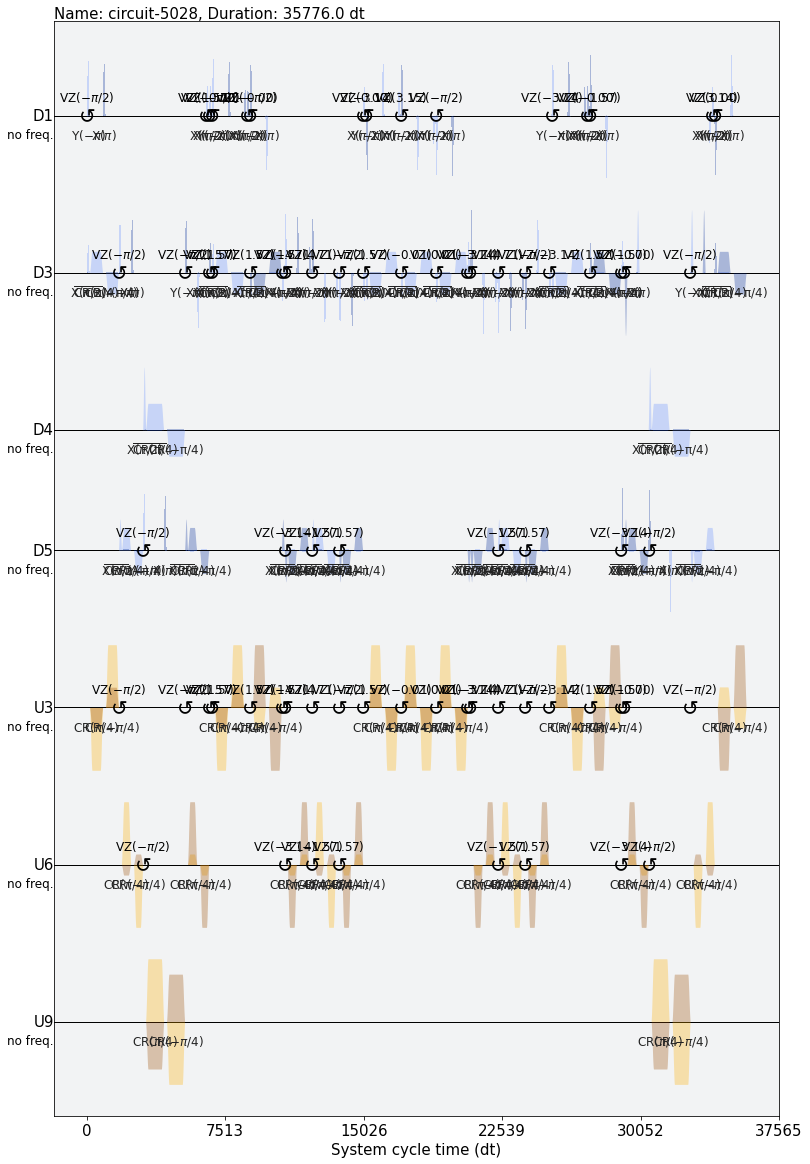

In [37]:
backend=jakarta
back_defaults = backend.defaults()
inst_map = back_defaults.instruction_schedule_map
sche = schedule(qc, backend=backend, inst_map=inst_map)
sche.draw()

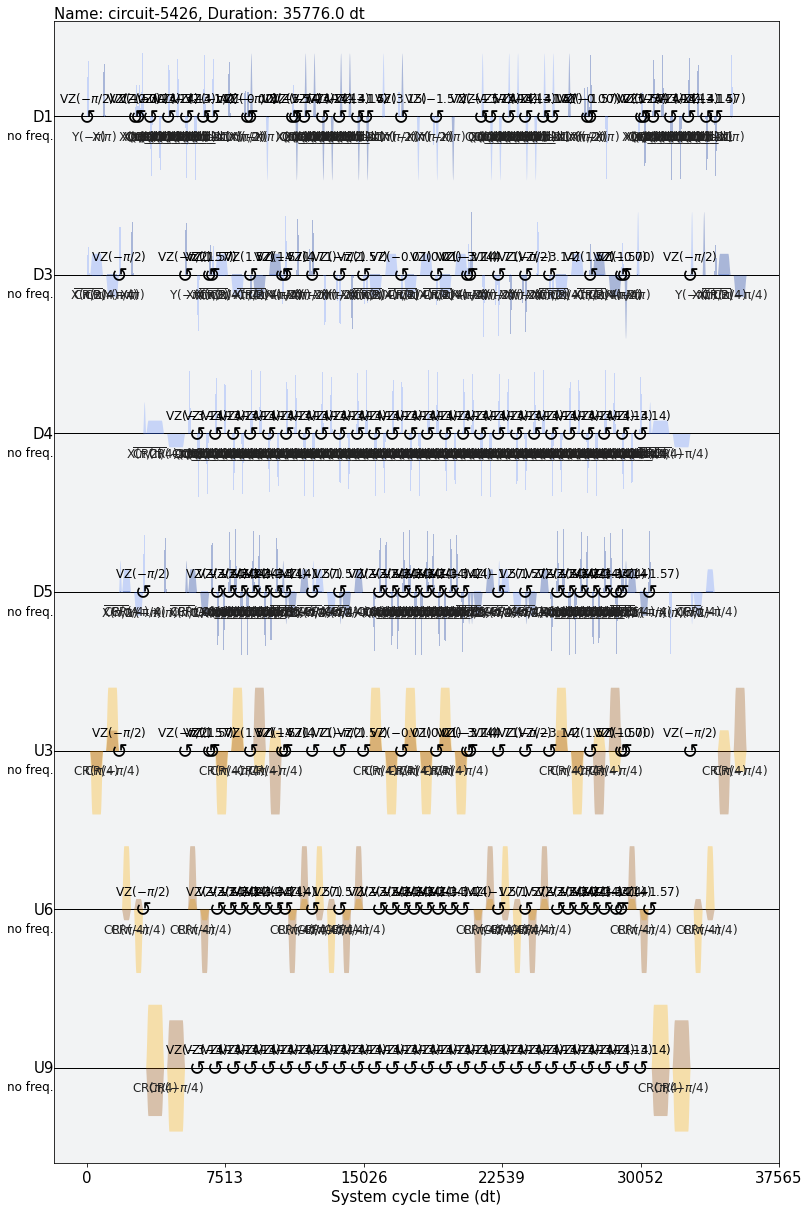

In [38]:
sche = schedule(dd_qc, backend=backend, inst_map=inst_map)
sche.draw()

It can be observed that after DD, the idle time of qubit are filled by the periodict pulse. And the total gate time keep the same. 
<br/>
In here, I would wish the judgers also have a check on DD that if it is implemented correctly and the total gate time doesn't increase when they run my solution. The calibration status are change day by day it is possible that the gate time change and this DD will increase the total gate time. If that happen, I wish that the judgers can adjust DD given the situation.

In the next several cells, I will run the solution for the target time and input state with the circuit with DD on a noise simulation backend. 

In [39]:
qr = QuantumRegister(7)
dd_qc_target = QuantumCircuit(qr)
dd_qc_target.append(target_input, [qr[0], qr[1], qr[2], qr[3], qr[4], qr[5], qr[6]])
dd_qc_target = transpile(dd_qc_target, optimization_level=0,backend=sim_noisy_jakarta, approximation_degree=1.)
dd_qc_target.append(dd_qc, [0, 1, 2, 3, 4, 5, 6])

dd_st_qcs_target_m = state_tomography_circuits(dd_qc_target, [1,3,5])
dd_st_qcs_target = []
for st_qc in dd_st_qcs_target_m:
    dd_st_qcs_target.append(st_qc.copy())
    cr=ClassicalRegister(1, "anx_mea")
    st_qc.add_register(cr)
    st_qc.measure([4], [cr[0]])



In [40]:
shots = 8192
reps = 8
#backend=sim
backend = sim_noisy_jakarta
#backend = jakarta

jobs_dd_target = []
for _ in range(reps):
    # execute
    job = execute(dd_st_qcs_target_m, backend, shots=shots, optimization_level=0)
    print('Job ID', job.job_id())
    jobs_dd_target.append(job)

Job ID 7934b517-ba08-489b-ace0-f8e4244ac4a5
Job ID 82a650c1-5f2b-4e2d-aad7-7c5e935614d7
Job ID 3792e59e-d543-411c-acb8-754bad3d49ce
Job ID 7a34707b-438e-49c5-8ba2-8f75ece99d35
Job ID a42a6118-e6c3-4fb5-aeae-9b0ecb2d914f
Job ID 0cbfa2e3-3875-4649-898a-7875cc821e7b
Job ID 6fce4c02-5419-4b4d-9720-9e82447e0521
Job ID bd452ccf-99c7-44e6-8aea-b6976ecaab53


In [41]:
target_state = get_target_state(target_time ,One^One^Zero)

fids = []
for job in jobs_dd_target:
    raw_results = job.result()
    raw_results = err_mitig.filter.apply(raw_results)
    new_results = copy.deepcopy(raw_results)
    for resultidx, _ in enumerate(raw_results.results):
        old_counts = raw_results.get_counts(resultidx)
        new_counts = {}
        new_results.results[resultidx].header.creg_sizes = [new_results.results[resultidx].header.creg_sizes[0]]
        new_results.results[resultidx].header.clbit_labels = new_results.results[resultidx].header.clbit_labels[0:-1]
        new_results.results[resultidx].header.memory_slots = 3
        
        for reg_key in old_counts:
            reg_bits = reg_key.split(' ')
            if reg_bits[0]=='0':
                new_counts[reg_bits[1]]=old_counts[reg_key]
       
        new_results.results[resultidx].data.counts = new_counts

    fid = state_tomo(new_results, dd_st_qcs_target, target_state)
    fids.append(fid)
    
print('state tomography fidelity for target time and initial state with dd = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

state tomography fidelity for target time and initial state with dd = 0.9411 ± 0.0020


The state fidelity for the noise simulation is $0.9411 \pm 0.002$. It is little lower than the noise simulation without DD. However, this is just the simulation, the performance with DD need to be checked on the real device.

In the next several cells, I retrieve the jobs which were ran on the real device with the DD for the target time and input state.

In [43]:

ids= [
     "62539c84cfe45c1189e5c0a4",
     "62539c87a5d4eef70f77eabc",
     "62539c8bf65d785d98392085",
     "62539c8e5ab79b02c7f96f6b",
     "62539c91182d0201aa4c4714",
     "62539c9573968c52c107cf7d",
     "62539c98fdf3772f7d570f2a",
     "62539c9bcfe45c51c7e5c0a5",
     ]
jobs_dd_target = []
for idx in ids:
    job = jakarta.retrieve_job(idx)
    jobs_dd_target.append(job)

Again, I retrieve the calibration status of the device when DD circuit was ran for the error mitigation.

In [44]:
sim_noisy_jakarta.properties=jobs_dd_target[3].properties

In [45]:
shots =2**16
backend = sim_noisy_jakarta
#backend = jakarta
qr = QuantumRegister(7)
meas_calibs, state_labels = complete_meas_cal(qubit_list=[4, 1, 3, 5], qr=qr, circlabel='mcal')
jobs_readout = []
for _ in range(8):
    # execute
    job = execute(meas_calibs, backend, shots=shots, optimization_level=None)
    print('Job ID', job.job_id())
    jobs_readout.append(job)

print('Job ID', job.job_id())

Job ID 719eaa35-e015-467e-8782-f32db004a4f2
Job ID 90b08398-9d8b-4213-bccd-937209e645f7
Job ID a2655ca4-c2a1-430e-b39d-c0ab22912a03
Job ID ef31e268-9cb9-4099-a37d-5dd6a2640c03
Job ID 6978620e-c189-4d69-a4c0-a029d78ebd7b
Job ID 72a85c3d-e226-47dd-b1da-4cb3de740560
Job ID c26384e9-e43c-45ba-8fb1-11b8e699a244
Job ID 8f515a0d-eedf-4928-9e28-1c9853be0617
Job ID 8f515a0d-eedf-4928-9e28-1c9853be0617


IOStream.flush timed out


In [46]:
results = [job.result() for job in jobs_readout]
meas_fitter = CompleteMeasFitter(results, state_labels, circlabel='mcal')
err_mitig = copy.deepcopy(meas_fitter)

for i in range(len(meas_fitter.state_labels)):
    state_label_raw = meas_fitter.state_labels[i]
    state_label = state_label_raw[0] + ' ' + state_label_raw[1:4]
    err_mitig.state_labels[i] = state_label

In [47]:
target_state = get_target_state(target_time ,One^One^Zero)

fids = []
for job in jobs_dd_target:
    raw_results = job.result()
    raw_results = err_mitig.filter.apply(raw_results)
    new_results = copy.deepcopy(raw_results)
    for resultidx, _ in enumerate(raw_results.results):
        old_counts = raw_results.get_counts(resultidx)
        new_counts = {}
        new_results.results[resultidx].header.creg_sizes = [new_results.results[resultidx].header.creg_sizes[0]]
        new_results.results[resultidx].header.clbit_labels = new_results.results[resultidx].header.clbit_labels[0:-1]
        new_results.results[resultidx].header.memory_slots = 3
        
        for reg_key in old_counts:
            reg_bits = reg_key.split(' ')
            if reg_bits[0]=='0':
                new_counts[reg_bits[1]]=old_counts[reg_key]
       
        new_results.results[resultidx].data.counts = new_counts

    fid = state_tomo(new_results, dd_st_qcs_target, target_state)
    fids.append(fid)
    
print('state tomography fidelity for target time and initial state with dd = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

state tomography fidelity for target time and initial state with dd = 0.8837 ± 0.0046


A state tomography fidelity $0.8839 \pm 0.0047$ is obtained. About 1% improvement compared to no DD version of the result. It is hard to tell that if there is improvement with DD. However, I will still keep DD version as my final solution according to my study for the DD with the individual qubit. 

In the last part of the solution, I will test my solution the with the evolution time $\pi/2$ and input state $(|110>+|010>)/\sqrt{2}$. 

In the next several cells, I will created a circuit for the evolution time $\pi/2$ and target input state.

In [48]:
qr = QuantumRegister(7)
qc = QuantumCircuit(qr)

qc.append(zzz, [qr[1], qr[3], qr[5], qr[4]])
qc.append(Trot_half_pi, [qr[0], qr[1], qr[2], qr[3], qr[4], qr[5], qr[6]])
qc.append(zzz, [qr[1], qr[3], qr[5], qr[4]])
qc = transpile(qc, optimization_level=3,backend=sim_noisy_jakarta, approximation_degree=1.)
dd_qc = dd_circuit(qc)

Again, the pulse schdule is checked to verify that if DD is implemented correctly.

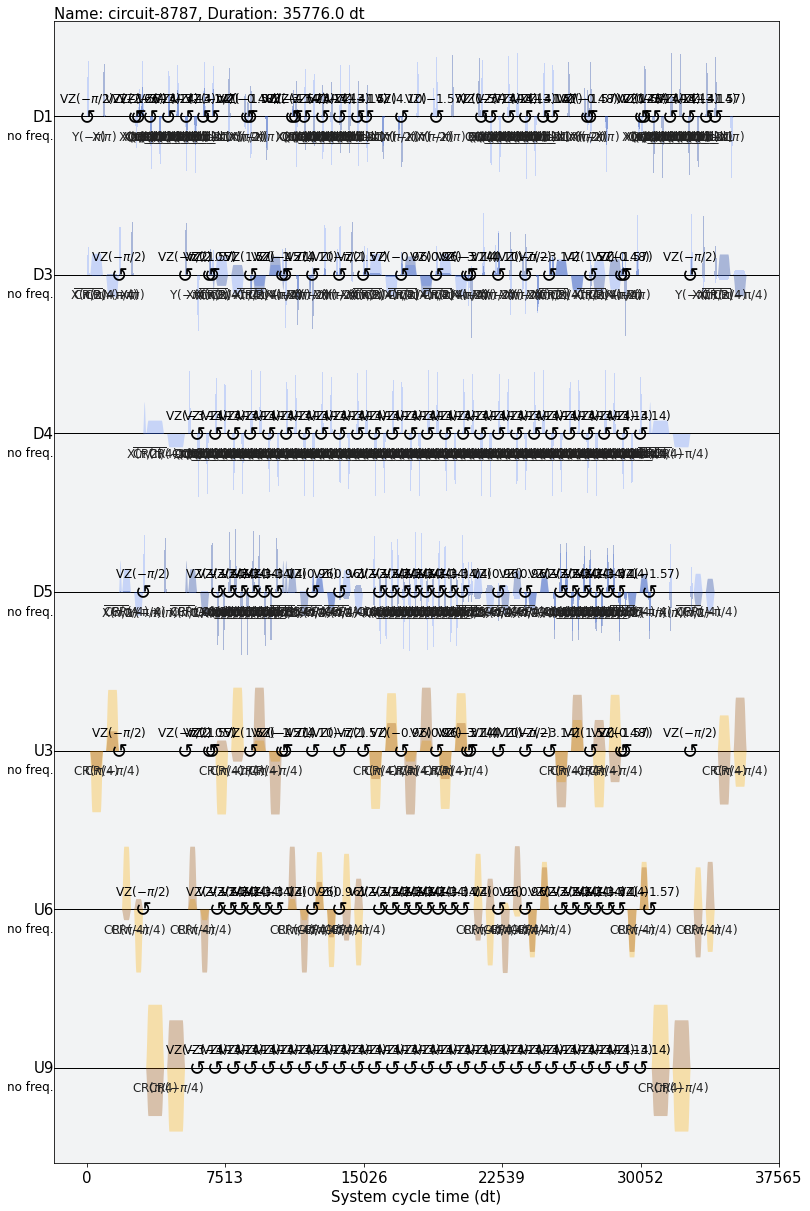

In [49]:
backend=jakarta
back_defaults = backend.defaults()
inst_map = back_defaults.instruction_schedule_map
sche = schedule(dd_qc, backend=jakarta, inst_map=inst_map)
sche.draw()

The tomograph circuits are created and ran in noise simulation backend.

In [50]:
qr = QuantumRegister(7)
dd_qc_half = QuantumCircuit(qr)
dd_qc_half.append(target_input, [qr[0], qr[1], qr[2], qr[3], qr[4], qr[5], qr[6]])
dd_qc_half = transpile(dd_qc_half, optimization_level=0,backend=sim_noisy_jakarta, approximation_degree=1.)
dd_qc_half.append(dd_qc, [0, 1, 2, 3, 4, 5, 6])

dd_st_qcs_half_m = state_tomography_circuits(dd_qc_half, [1,3,5])
dd_st_qcs_half = []
for st_qc in dd_st_qcs_half_m:
    dd_st_qcs_half.append(st_qc.copy())
    cr=ClassicalRegister(1, "anx_mea")
    st_qc.add_register(cr)
    st_qc.measure([4], [cr[0]])

In [51]:
shots = 8192
reps = 8
#backend=sim
backend = sim_noisy_jakarta
#backend = jakarta

jobs_dd_half = []
for _ in range(reps):
    # execute
    job = execute(dd_st_qcs_half_m, backend, shots=shots, optimization_level=0)
    print('Job ID', job.job_id())
    jobs_dd_half.append(job)

Job ID dfbea93b-7a42-4ec4-bf94-00cfa7c1fc26
Job ID 9e2812a5-ce32-4cc1-813f-78f4939f09d0
Job ID de198256-6de9-4c4e-9f15-ce02ebe13a4a
Job ID 9307d989-cf8d-4d93-a21e-01096c240972
Job ID a2c216d0-343f-41ca-a5f6-5826a2c70042
Job ID 9ab3adc6-cb6c-430b-a5f1-0393cc0c419c
Job ID 6e6baa39-97b7-4072-8112-fd1c2114bba4
Job ID 8b625c69-7b20-4c29-8fe6-799058c909f6


The The state fidelity for the noise simulation is $0.8455 \pm 0.0019$ with the evolution time $\pi/2$.

In [52]:
target_state = get_target_state(target_time/2 ,One^One^Zero)

fids = []
for job in jobs_dd_half:
    raw_results = job.result()
    raw_results = err_mitig.filter.apply(raw_results)
    new_results = copy.deepcopy(raw_results)
    for resultidx, _ in enumerate(raw_results.results):
        old_counts = raw_results.get_counts(resultidx)
        new_counts = {}
        new_results.results[resultidx].header.creg_sizes = [new_results.results[resultidx].header.creg_sizes[0]]
        new_results.results[resultidx].header.clbit_labels = new_results.results[resultidx].header.clbit_labels[0:-1]
        new_results.results[resultidx].header.memory_slots = 3
        
        for reg_key in old_counts:
            reg_bits = reg_key.split(' ')
            if reg_bits[0]=='0':
                new_counts[reg_bits[1]]=old_counts[reg_key]
       
        new_results.results[resultidx].data.counts = new_counts

    fid = state_tomo(new_results, dd_st_qcs_half, target_state)
    fids.append(fid)
    
print('state tomography fidelity for 0.5 pi time and initial state with dd = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

state tomography fidelity for 0.5 pi time and initial state with dd = 0.8455 ± 0.0019


Again, I retrieve the jobs which were ran on the real device and the calibration status of the device when those jobs were ran for error mitigation.  

In [54]:

ids= [
     "62539faefdf377eaba570f4b",
     "62539fb273968c4faa07cf96",
     "62539fb5fdf3770abb570f4c",
     "62539fbaa5d4ee3b0a77ead5",
     "62539fc0cfe45cacc7e5c0c3",
     "62539fc4f65d787efa392095",
     "62539fc7182d02d2ff4c4729",
     "62539fcffdf377e751570f4d",
     ]
jobs_dd_half = []
for idx in ids:
    job = jakarta.retrieve_job(idx)
    jobs_dd_half.append(job)

In [55]:
sim_noisy_jakarta.properties=jobs_dd_half[3].properties
shots =2**16
backend = sim_noisy_jakarta
#backend = jakarta
qr = QuantumRegister(7)
meas_calibs, state_labels = complete_meas_cal(qubit_list=[4, 1, 3, 5], qr=qr, circlabel='mcal')
jobs_readout = []
for _ in range(8):
    # execute
    job = execute(meas_calibs, backend, shots=shots, optimization_level=None)
    print('Job ID', job.job_id())
    jobs_readout.append(job)

print('Job ID', job.job_id())

Job ID e95804a5-2e33-459b-8e55-bf334084c911
Job ID 7bd26c65-9f41-4a4a-9ed2-a26a9b002614
Job ID 04fb81fb-a905-4ba9-95ae-4e8372244ceb
Job ID 080b4c1e-da0c-4863-8b27-503b83c7085d
Job ID 51ea4fe7-2aee-4337-b1e4-b72c0b1c3c64
Job ID 5777f2a4-53eb-46b0-b419-cc5a1ef9057e
Job ID 02789eff-93aa-4963-9079-64597e6ad8f3
Job ID ee24822f-ddab-46f7-a855-58abe1ba5843
Job ID ee24822f-ddab-46f7-a855-58abe1ba5843


In [56]:
results = [job.result() for job in jobs_readout]
meas_fitter = CompleteMeasFitter(results, state_labels, circlabel='mcal')
err_mitig = copy.deepcopy(meas_fitter)

for i in range(len(meas_fitter.state_labels)):
    state_label_raw = meas_fitter.state_labels[i]
    state_label = state_label_raw[0] + ' ' + state_label_raw[1:4]
    err_mitig.state_labels[i] = state_label

In [57]:
target_state = get_target_state(target_time/2 ,One^One^Zero)

fids = []
for job in jobs_dd_half:
    raw_results = job.result()
    raw_results = err_mitig.filter.apply(raw_results)
    new_results = copy.deepcopy(raw_results)
    for resultidx, _ in enumerate(raw_results.results):
        old_counts = raw_results.get_counts(resultidx)
        new_counts = {}
        new_results.results[resultidx].header.creg_sizes = [new_results.results[resultidx].header.creg_sizes[0]]
        new_results.results[resultidx].header.clbit_labels = new_results.results[resultidx].header.clbit_labels[0:-1]
        new_results.results[resultidx].header.memory_slots = 3
        
        for reg_key in old_counts:
            reg_bits = reg_key.split(' ')
            if reg_bits[0]=='0':
                new_counts[reg_bits[1]]=old_counts[reg_key]

        new_results.results[resultidx].data.counts = new_counts

    fid = state_tomo(new_results, dd_st_qcs_half, target_state)
    fids.append(fid)
    
print('state tomography fidelity for 0.5 pi time and initial state with dd = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

state tomography fidelity for 0.5 pi time and initial state with dd = 0.8209 ± 0.0099


The state tomography fidelity is $0.8208 \pm 0.01$ which is significant lower than the target time and input state.

In the following cells, I test the performance of the solution with input state $(|110>+|010>)/\sqrt{2}$, which is the most difficult case since the qubit 4 stays in the superposition of "0" and "1" for a long time. I expect that the result suffer from large dephase compared to the other two cases.
<br/>

Again, I create the circuit and check the pulse schedule.

In [58]:
qr = QuantumRegister(7)
qc = QuantumCircuit(qr)

qc.append(zzz, [qr[1], qr[3], qr[5], qr[4]])
qc.append(Trot_pi, [qr[0], qr[1], qr[2], qr[3], qr[4], qr[5], qr[6]])
qc.append(zzz, [qr[1], qr[3], qr[5], qr[4]])
qc = transpile(qc, optimization_level=3,backend=sim_noisy_jakarta, approximation_degree=1.)
dd_qc = dd_circuit(qc)

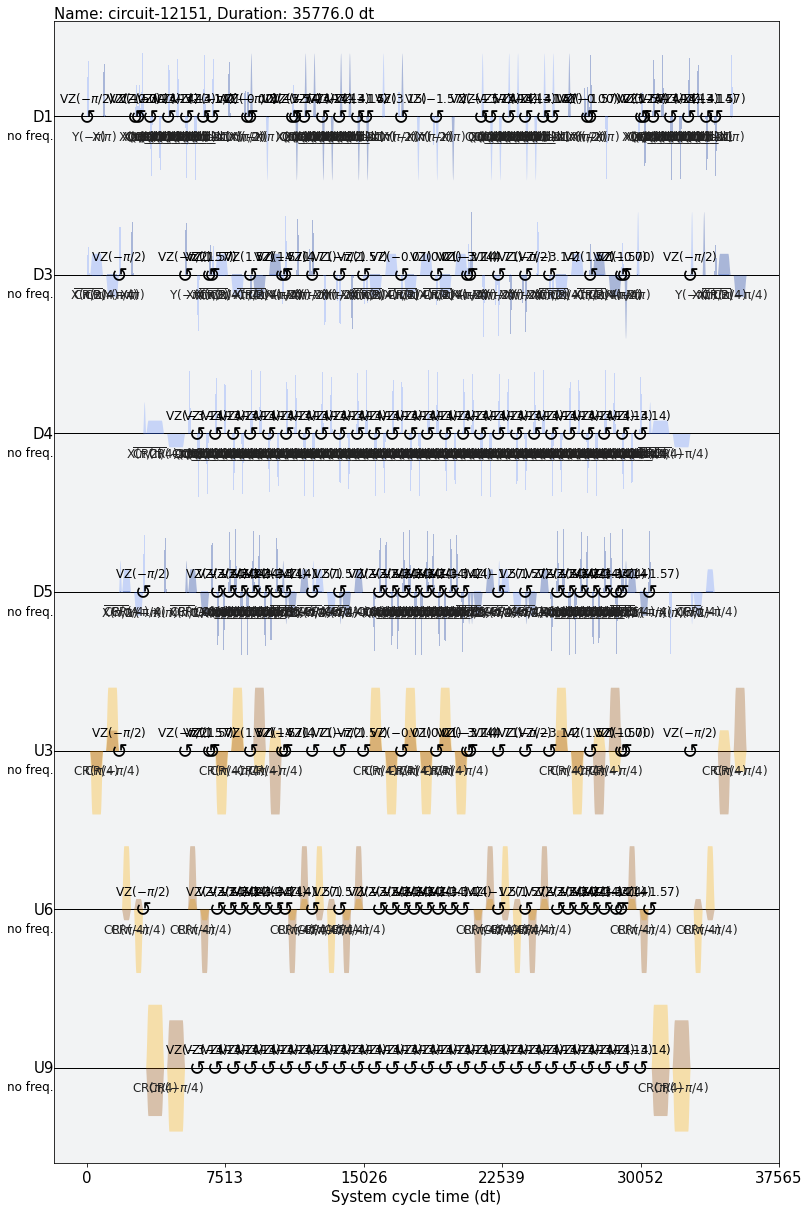

In [59]:
sche = schedule(dd_qc, backend=backend, inst_map=inst_map)
sche.draw()

Run the circuit on the noise simulation.

In [60]:
qr = QuantumRegister(7)
dd_qc_ext = QuantumCircuit(qr)
dd_qc_ext.append(ext_input, [qr[0], qr[1], qr[2], qr[3], qr[4], qr[5], qr[6]])
dd_qc_ext = transpile(dd_qc_ext, optimization_level=0,backend=sim_noisy_jakarta, approximation_degree=1.)
dd_qc_ext.append(dd_qc, [0, 1, 2, 3, 4, 5, 6])

dd_st_qcs_ext_m = state_tomography_circuits(dd_qc_ext, [1,3,5])
dd_st_qcs_ext = []
for st_qc in dd_st_qcs_ext_m:
    dd_st_qcs_ext.append(st_qc.copy())
    cr=ClassicalRegister(1, "anx_mea")
    st_qc.add_register(cr)
    st_qc.measure([4], [cr[0]])

In [61]:
shots = 8192
reps = 8
#backend=sim
backend = sim_noisy_jakarta
#backend = jakarta

jobs_dd_ext = []
for _ in range(reps):
    # execute
    job = execute(dd_st_qcs_ext_m, backend, shots=shots, optimization_level=0)
    print('Job ID', job.job_id())
    jobs_dd_ext.append(job)

Job ID 30b88e72-3fe3-42db-8631-4e95fe8d93ef
Job ID e4e2a2e6-9015-42f9-bd38-3176843d8aae
Job ID 82172c40-3281-481e-b0a4-4808a2f8b090
Job ID 48bb9b71-fe82-4c29-9581-f859e5796b89
Job ID ed71490e-0d72-4a0f-9a67-aefc488b0ef8
Job ID 7865418f-ca96-4300-a369-1dcea752289a
Job ID 0f7d52e3-d5c7-4aea-8a46-36c206c00681
Job ID f3b66940-bb09-4230-b5a8-86237ae18fac


The state tomography fidelity for target time and $|110>+|010>/\sqrt{2}$ with the noise simulation is $0.8927 \pm 0.0018$

In [62]:
target_state = get_target_state(target_time ,((Zero+One)/np.sqrt(2))^One^Zero)

fids = []
for job in jobs_dd_ext:
    raw_results = job.result()
    raw_results = err_mitig.filter.apply(raw_results)
    new_results = copy.deepcopy(raw_results)
    for resultidx, _ in enumerate(raw_results.results):
        old_counts = raw_results.get_counts(resultidx)
        new_counts = {}
        new_results.results[resultidx].header.creg_sizes = [new_results.results[resultidx].header.creg_sizes[0]]
        new_results.results[resultidx].header.clbit_labels = new_results.results[resultidx].header.clbit_labels[0:-1]
        new_results.results[resultidx].header.memory_slots = 3
        
        for reg_key in old_counts:
            reg_bits = reg_key.split(' ')
            if reg_bits[0]=='0':
                new_counts[reg_bits[1]]=old_counts[reg_key]
       
        new_results.results[resultidx].data.counts = new_counts

    fid = state_tomo(new_results, dd_st_qcs_ext, target_state)
    fids.append(fid)
    
print('state tomography fidelity for target time and |110> + |010> superposition state with dd = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

state tomography fidelity for target time and |110> + |010> superposition state with dd = 0.8927 ± 0.0011


Again, I retrieve the results from the real device.

In [63]:

ids= [
      "6253a1ef73968c7c8007cfac",
      "6253a1f5182d0251634c4735",
      "6253a1fbcaa265193af1b7cb",
      "6253a1fef65d7851173920a6",
      "6253a2014b5152f8027c8889",
      "6253a206fdf3772ca7570f5e",
      "6253a20bcaa2658ceaf1b7cc",
      "6253a211fdf3775364570f5f",
      ]
jobs_dd_ext = []
for idx in ids:
    job = jakarta.retrieve_job(idx)
    jobs_dd_ext.append(job)

In [64]:
sim_noisy_jakarta.properties=jobs_dd_ext[3].properties
shots =2**16
backend = sim_noisy_jakarta
#backend = jakarta
qr = QuantumRegister(7)
meas_calibs, state_labels = complete_meas_cal(qubit_list=[4, 1, 3, 5], qr=qr, circlabel='mcal')
jobs_readout = []
for _ in range(8):
    # execute
    job = execute(meas_calibs, backend, shots=shots, optimization_level=None)
    print('Job ID', job.job_id())
    jobs_readout.append(job)

print('Job ID', job.job_id())

Job ID cec281f4-d066-4c0b-912b-57e8898d629a
Job ID 189091f4-a067-4709-a6f1-74eb6179ffcb
Job ID 87640bd7-198d-4ce6-a50f-ef93eabcb875
Job ID 6dd0ee2d-d876-406d-b0db-e253b65993ec
Job ID 64d08eb5-1305-4b8d-bca5-0d0e07034a54
Job ID e0d87b6e-d5e5-4812-b973-f8d4f206ace1
Job ID 6bc3dd19-a37e-4758-a851-60813def96c5
Job ID 21277585-551e-48ca-a3a2-7e0e07948014
Job ID 21277585-551e-48ca-a3a2-7e0e07948014


IOStream.flush timed out


In [65]:
results = [job.result() for job in jobs_readout]
meas_fitter = CompleteMeasFitter(results, state_labels, circlabel='mcal')
err_mitig = copy.deepcopy(meas_fitter)

for i in range(len(meas_fitter.state_labels)):
    state_label_raw = meas_fitter.state_labels[i]
    state_label = state_label_raw[0] + ' ' + state_label_raw[1:4]
    err_mitig.state_labels[i] = state_label

In [66]:
target_state = get_target_state(target_time ,((Zero+One)/np.sqrt(2))^One^Zero)

fids = []
for job in jobs_dd_ext:
    raw_results = job.result()
    raw_results = err_mitig.filter.apply(raw_results)
    new_results = copy.deepcopy(raw_results)
    for resultidx, _ in enumerate(raw_results.results):
        old_counts = raw_results.get_counts(resultidx)
        new_counts = {}
        new_results.results[resultidx].header.creg_sizes = [new_results.results[resultidx].header.creg_sizes[0]]
        new_results.results[resultidx].header.clbit_labels = new_results.results[resultidx].header.clbit_labels[0:-1]
        new_results.results[resultidx].header.memory_slots = 3
        
        for reg_key in old_counts:
            reg_bits = reg_key.split(' ')
            if reg_bits[0]=='0':
                new_counts[reg_bits[1]]=old_counts[reg_key]
       
        new_results.results[resultidx].data.counts = new_counts

    fid = state_tomo(new_results, dd_st_qcs_ext, target_state)
    fids.append(fid)
    
print('state tomography fidelity for target time and |110> + |010> superposition state with dd = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

state tomography fidelity for target time and |110> + |010> superposition state with dd = 0.8648 ± 0.0094


The state tomography fidelity for target time and $|010>+|110>/\sqrt{2}$ input state on real device is $0.8648 \pm 0.0094$

# Reference:

1. S. Gulania, B. Peng, Y. Alexeev, and N. Govind, "Quantum time dynamics of 1D-Heisenberg models employ- ing the Yang-Baxter equation for circuit compression", arXiv:2112.01690(2021).

2. L. Bassman, R. Van Beeumen, E. Younis, E. Smith, C. Iancu, W. de Jong, Constant-depth circuits for dynamic simulations of materials on quantum computers, arXiv:2103.07429(2021).

3. X. Bonet-Monroig, R. Sagastizabal, M. Singh, T. E. O’Brien, "Low-cost error mitigation by symmetry verification", PHYSICAL REVIEW A 98, 062339(2018). 

4. B. Pokharel, N. Anand, B. Fortman, D. Lidar, "Demonstration of fidelity improvement using dynamical decoupling with superconducting qubits", arXiv:1807.08768(2018).

# Appendix. A 
## Eigenstate and values of the target Hamilitonian

Eigenvalue:
$$
\lambda = 2
$$
Eigentates:
$$
|111>
$$
$$
|000>
$$
$$
(|001>+|010>+|100>)/\sqrt{3}
$$
$$
(|011>+|110>+|101>)/\sqrt{3}
$$
Eigenvalue:
$$
\lambda = 0
$$
Eigentates:
$$
(|001>-|100>)/\sqrt{2}
$$
$$
(|011>-|110>)/\sqrt{2}
$$

Eigenvalue:
$$
\lambda = -4
$$
Eigentates:
$$
(|001>+|100>-2|010>)/\sqrt{6}
$$
$$
(|011>+|110>-2|101>)/\sqrt{6}
$$

#dd

Job ID 625adf487368943fc2c8bb9b
Job ID 625adf4c8e4b2378e3d308fc
Job ID 625adf4f8e4b23c4f1d308fd
Job ID 625adf51f1fb8dd7eb3ad7f5
Job ID 625adf54a7e96632acdee72c
Job ID 625adf55e3b67f3c783abc4f
Job ID 625adf58e1f24510d8eb6bab
Job ID 625adf5a7368947215c8bb9c

# no dd

Job ID 625adf6835e1ecb1eb25361b
Job ID 625adf698e4b23ec41d308ff
Job ID 625adf6aa7e9664fdfdee72d
Job ID 625adf6be3b67ffebc3abc50
Job ID 625adf6c35e1ec897725361c
Job ID 625adf6ee1f245778eeb6bac
Job ID 625adf6f0d8f19682cac1972
Job ID 625adf713bbc9f89b5735af7